In [1]:
import pandas as pd
pd.set_option("display.max_columns",999)
from Bio import SeqIO
from Bio import Seq
from Bio.Alphabet import generic_dna
import seaborn as sns
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from subprocess import *
%matplotlib inline

In [4]:
infile = SeqIO.read('/home/m/Desktop/clju_genomics/clju_gbk/Clostridium_autoethanogenum_DSM_10061_genome_size_4352446.gbk','gb')
genes =[]
name = []
product = []
func = []
strand = []
start = []
stop = []
aaseq = []
cds_seq = []
real_st=[]
real_sp=[]

    #genome_seq_df = pd.DataFrame({'sequence':list(str(infile.seq))},index=range(1,len(str(infile.seq))+1))
for feature in infile.features:
    if feature.type == 'CDS' and 'product' in feature.qualifiers:  #Only cares for coding sequences which are not pseudogenes
        genes.append(feature.qualifiers['locus_tag'][0])
        try: name.append(feature.qualifiers['gene'][0])
        except: name.append('')
        product.append(feature.qualifiers['product'][0])
        #cds_seq.append(feature.location.extract(infile.seq).tostring())
        if 'function' in feature.qualifiers:                       #not all genes have known functions
            func.append(feature.qualifiers['function'][0])
        else:
            func.append("N/A")
        try:
            aaseq.append(feature.qualifiers['translation'][0])
        except:
            aaseq.append("N/A")
        if feature.strand == 1:
            strand.append("plus")
            real_st.append(feature.location.start.real+1)
            real_sp.append(feature.location.end.real)
            st=feature.location.start.real-25 #takes the 25 bp in the 5UTR upstream of start codon in plus strand
            sp=feature.location.start.real
            start.append(st)
            stop.append(sp)
            cds_seq.append(str(infile.seq[st:sp]))
        elif feature.strand == -1:
            real_st.append(feature.location.start.real+1)
            real_sp.append(feature.location.end.real)
            strand.append("minus")
            st=feature.location.end.real
            sp=feature.location.end.real+25 #takes the 25 bp in the 5UTR upstream of start codon in minus strand
            start.append(st)
            stop.append(sp)
            my_seq = str(infile.seq[st:sp])
            my_seq = Seq.reverse_complement(my_seq)
            cds_seq.append(my_seq)
gene_df = pd.DataFrame({"gene_id": genes,  "product": product, "strand": strand, "start": start, "stop": stop, 
                        "cds_seq":cds_seq,"aaseq": aaseq, "real_st" :real_st, "real_sp": real_sp},
                          columns = ["gene_id",  "product", "strand", "start", "stop", "cds_seq","aaseq",'real_st', 'real_sp'])


###### cds_seq is actually the 25 upstream of the 5'UTR!!! #######

In [5]:
gene_df.head()

,gene_id,product,strand,start,stop,cds_seq,aaseq,real_st,real_sp
0,CLAU_RS00005,molybdenum-pterin-binding protein,plus,52,77,TATGGCGGCAAGATGGGGGTAAAAA,MIISARNQITGKTESVKEGAVNAIVTLKADDGNTITSTISMAAVKD...,78,284
1,CLAU_RS00010,hypothetical protein,minus,780,805,ATGCACTATATGGTTTGAATTAAGA,MNEIGLFFNPSWENTSTTALINVAENNIGFAVLPFQLIKDHIASGS...,523,780
2,CLAU_RS00015,peroxiredoxin,minus,1249,1274,ACTATATTTGAAGGGAGTGATTTTA,MPLTTVKAVVEKKDGIAVEAHSGGFKVLLDKTKQSGGTNKGMNPAQ...,788,1249
3,CLAU_RS00020,glyoxylate reductase,plus,1339,1364,AATTTACATAGAGGAAGTGGTATAT,MKIVILDGYVLNPGDLSWSSLEKLGDLTVYDKTIFDNSNDDLIIER...,1365,2339
4,CLAU_RS00025,peptidase T,plus,2357,2382,AATATTATTTAAGGGGAAATTGATA,MSKVVERFVKYVKYDTRSDENSTTVPTTRGQLELAKELSKELKNIG...,2383,3609


In [7]:
### This method takes each 5'UTR sequence from gene_df and returns the lowest ∆G 
### of the sequence by comparing walking windows of 10nt at a time. 
### You need to install RNAsubopt, I think it is part of the viennaRNA package

SD_start=[]
SD_end=[]
SD_dg=[]
SD_seq=[]
genes=[]


for index, row in gene_df.iterrows():

    seq = row['cds_seq']
    fromm=row['start']
    gene_id=row['gene_id']
    scores=[]
    position_from=[]
    position_to=[]
    
    #for i in range(0,(len(seq)+1)-10): # windows of 10 nts step 1 to cover all seq
    for i in range(0,16):
        newseq= seq[i:i+10]
        fromm=fromm + 1
        f=open('/home/m/Desktop/clju_genomics/ff', 'w') #write each window seq
        writing= ">{}\nACCTCCTT&{}\n".format(fromm,newseq)
        f.write(writing)
        f.close()
        command = 'RNAsubopt -e 1 -s --noconv < ~/Desktop/clju_genomics/ff'
        output=check_output(command, shell = True)
            ####dealing with the RNAsubopt results####
        array = output.split('\n')
       
        scores.append(array[1]) #element 1 contains the scores
        coordinates=(array[0][1:-6])
        position_from.append(coordinates)
        position_to.append(int(coordinates)+9)
        
        
    dg=[]
    seq_ar=[]
        
    for j in scores: #this calculates the minimum delta G and the element position of the minimum deltaG
        deltaG=j.split()[1]
        seq1 = j.split()[0]
        seq_ar.append(seq1)
        dg.append(np.float64(deltaG))
    final_dg=np.min(dg) #this calculates the minimum delta G and the element position of the minimum deltaG
    final_element=np.argmin(dg) # the element position of the minimum deltaG
    final_from=position_from[final_element]
    final_to = position_to[final_element]
    seq2=seq_ar[final_element]
    seq3=seq2[9:]
    SD_start.append(final_from)
    SD_end.append(final_to)
    SD_dg.append(final_dg)
    SD_seq.append(seq3)
    genes.append(gene_id)
       
RBS_df =pd.DataFrame({'gene_id':genes,
                     'RBS_start':SD_start,
                     'RBS_end':SD_end,
                     'RBS_dg':SD_dg,
                     'RBS_seq':SD_seq},
                    columns=['gene_id','RBS_start', 'RBS_end', 'RBS_dg', 'RBS_seq'])

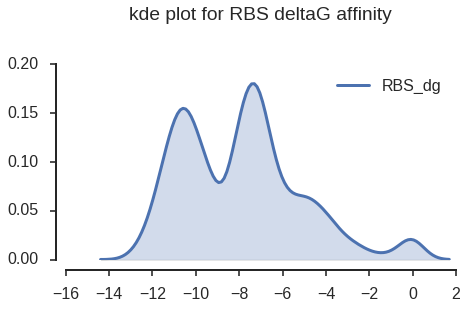

In [9]:
fig, ax = plt.subplots(figsize=(7,3.5))
sns.set_style('ticks')
sns.set_context('poster')
sns.despine(offset=10)
#sns.kdeplot(RBS_df_2.RBS_dist_ATG, shade=True, ax=ax, linewidth=3)
sns.kdeplot(RBS_df.RBS_dg, shade=True, ax=ax, linewidth=3)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.ticklabel_format(fontsize=20)
plt.title('kde plot for RBS deltaG affinity\n\n')

In [10]:
## adding the RNAsubopt results into gene_df
RBS_df_2=pd.merge(RBS_df, gene_df)

In [20]:
RBS_df_2

,gene_id,RBS_start,RBS_end,RBS_dg,RBS_seq,product,strand,start,stop,cds_seq,aaseq,real_st,real_sp,RBS_dist_ATG
0,CLAU_RS00005,64,73,-9.7,GATGGGGGTA,molybdenum-pterin-binding protein,plus,78,284,TATGGCGGCAAGATGGGGGTAAAAA,MIISARNQITGKTESVKEGAVNAIVTLKADDGNTITSTISMAAVKD...,78,284,10
1,CLAU_RS00010,786,795,-2.2,CTATATGGTT,hypothetical protein,minus,523,780,ATGCACTATATGGTTTGAATTAAGA,MNEIGLFFNPSWENTSTTALINVAENNIGFAVLPFQLIKDHIASGS...,523,780,10
2,CLAU_RS00015,1258,1267,-7.2,TGAAGGGAGT,peroxiredoxin,minus,788,1249,ACTATATTTGAAGGGAGTGATTTTA,MPLTTVKAVVEKKDGIAVEAHSGGFKVLLDKTKQSGGTNKGMNPAQ...,788,1249,13
3,CLAU_RS00020,1349,1358,-6.0,AGAGGAAGTG,glyoxylate reductase,plus,1365,2339,AATTTACATAGAGGAAGTGGTATAT,MKIVILDGYVLNPGDLSWSSLEKLGDLTVYDKTIFDNSNDDLIIER...,1365,2339,12
4,CLAU_RS00025,2365,2374,-7.0,TTTAAGGGGA,peptidase T,plus,2383,3609,AATATTATTTAAGGGGAAATTGATA,MSKVVERFVKYVKYDTRSDENSTTVPTTRGQLELAKELSKELKNIG...,2383,3609,14
5,CLAU_RS00030,3615,3624,-6.5,GTTTGGGAGC,LuxR family transcriptional regulator,plus,3633,6290,AAAAAGTGTTTGGGAGCAGAGAAAA,MLLNYKYNNTKFLIPKKKCKIIDREKVLSRLDEVLETKLTIISAAA...,3633,6290,14
6,CLAU_RS00035,6481,6490,-10.8,ATAAGGAGGC,peptidase T,plus,6496,7722,TGGAGATATTATAAGGAGGCTGAAC,MSKVVEKFTKYIKFDTRSNEEMNTVPTTQGQMVLAKELSKELKKIG...,6496,7722,11
7,CLAU_RS00040,7735,7744,-10.9,TAAAGGAGGA,glutamate/gamma-aminobutyrate family transport...,plus,7752,9257,TAAATTAATAAAGGAGGAGAGAAAG,MESTEQKQKKMTLIALVLMIFTSVFGFTNIPRAFYLMGYGAIPWYI...,7752,9257,13
8,CLAU_RS00045,10004,10013,-5.8,ATTGAGAGGA,DUF3298 domain-containing protein,minus,9319,9993,AAAAACTATTATTGAGAGGATACAA,MPHNHNISKNICPFAKYFFRNEASNGVILNTGKISPEKFSISYPFI...,9319,9993,15
9,CLAU_RS00050,10164,10173,-5.5,TAAGGAAGTG,signal transduction protein,plus,10179,11381,AAGTATGTTTTAAGGAAGTGATAAT,MDAFIARQPIFNKKEKVVAYELLYRDSFENYYKGNDEDKATCNVIA...,10179,11381,11


In [ ]:
## slicing the df

RBS_df_2=RBS_df_2[['gene_id', 'RBS_start', 'RBS_end', 'RBS_dg', 'RBS_seq', 'product',
       'strand', 'start', 'stop', 'real_st', 'real_sp']]

In [12]:
## calculating the distance of RBS to start codon
RBS_df_2.RBS_start=RBS_df_2.RBS_start.astype(np.float64)
RBS_df_2.RBS_end=RBS_df_2.RBS_end.astype(np.float64)
RBS_df_2.start=RBS_df_2.real_st.astype(np.float64)
RBS_df_2.stop=RBS_df_2.real_sp.astype(np.float64)
RBS_dist_ATG=[]
for i,x in RBS_df_2.iterrows():
    if x['strand']=='plus':
        RBS_dist_ATG.append(abs((x['RBS_start']+x['RBS_end'])//2- x['real_st']))
    elif x['strand']=='minus':
        RBS_dist_ATG.append(abs((x['RBS_start']+x['RBS_end'])//2- x['real_sp']))
        


In [13]:
RBS_df_2['RBS_dist_ATG']=RBS_dist_ATG

In [14]:
RBS_df_2.head()

,gene_id,RBS_start,RBS_end,RBS_dg,RBS_seq,product,strand,start,stop,cds_seq,aaseq,real_st,real_sp,RBS_dist_ATG
0,CLAU_RS00005,64,73,-9.7,GATGGGGGTA,molybdenum-pterin-binding protein,plus,78,284,TATGGCGGCAAGATGGGGGTAAAAA,MIISARNQITGKTESVKEGAVNAIVTLKADDGNTITSTISMAAVKD...,78,284,10
1,CLAU_RS00010,786,795,-2.2,CTATATGGTT,hypothetical protein,minus,523,780,ATGCACTATATGGTTTGAATTAAGA,MNEIGLFFNPSWENTSTTALINVAENNIGFAVLPFQLIKDHIASGS...,523,780,10
2,CLAU_RS00015,1258,1267,-7.2,TGAAGGGAGT,peroxiredoxin,minus,788,1249,ACTATATTTGAAGGGAGTGATTTTA,MPLTTVKAVVEKKDGIAVEAHSGGFKVLLDKTKQSGGTNKGMNPAQ...,788,1249,13
3,CLAU_RS00020,1349,1358,-6.0,AGAGGAAGTG,glyoxylate reductase,plus,1365,2339,AATTTACATAGAGGAAGTGGTATAT,MKIVILDGYVLNPGDLSWSSLEKLGDLTVYDKTIFDNSNDDLIIER...,1365,2339,12
4,CLAU_RS00025,2365,2374,-7.0,TTTAAGGGGA,peptidase T,plus,2383,3609,AATATTATTTAAGGGGAAATTGATA,MSKVVERFVKYVKYDTRSDENSTTVPTTRGQLELAKELSKELKNIG...,2383,3609,14


In [ ]:
RBS_df_2.to_excel('/home/m/Dropbox/Clostridium_paper/RBS_affinity/RBS_affitinity_df.xls')

In [3]:
RBS_df_2=pd.read_excel('/home/m/Dropbox/Clostridium_paper/RBS_affinity/RBS_affitinity_df.xls')

In [ ]:
fig, ax = plt.subplots(figsize=(7,3.5))
sns.set_style('ticks')
sns.set_context('poster')
sns.despine(offset=10)
#sns.kdeplot(RBS_df_2.RBS_dist_ATG, shade=True, ax=ax, linewidth=3)
sns.kdeplot(RBS_df_2.RBS_dg, shade=True, ax=ax, linewidth=3)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.ticklabel_format(fontsize=20)
plt.title('kde plot for RBS deltaG affinity\n\n')
plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/kde_plot_for_RBS_deltaG.pdf',
            bbox_inches='tight')

In [ ]:
## this figures represent an interesting results which is not a result of error in assigning deltaG as
## there is no difference between genes on minus or plus strands

RBS_df_2[RBS_df_2.RBS_dg<-9].strand.value_counts()

## The next question is whether the two separate peaks in the KDE plot correspond to different translational efficiencies

In [16]:
RBS_df_2.to_excel('/home/m/Desktop/clju_genomics/autoehtnogenum_rbs.xls')

In [ ]:
#omics_df=omics_df[['gene_id','co_te','hf_te','h2c_te']]

In [ ]:
RBS_df_2=pd.merge(RBS_df_2,omics_df)

## Remove Zero TE values and Take the 80th and 20th TE percentiles and remove any "inf" or NaN values

In [ ]:
RBS_df_2=RBS_df_2[(RBS_df_2.hf_te>0) & (RBS_df_2.co_te>0) &(RBS_df_2.h2c_te>0)]
hiTE=RBS_df_2[RBS_df_2.hf_te>np.percentile(RBS_df_2.hf_te, 80)] #take 80 percentile and above
hiTE.fillna(0, inplace=True)
hiTE=hiTE.replace([np.inf, -np.inf], np.nan).dropna(subset=["hf_te", "co_te", "h2c_te"], how="all")
lowTE=RBS_df_2[RBS_df_2.hf_te<np.percentile(RBS_df_2.hf_te, 20)] #take 20 percentile and below
lowTE.fillna(0, inplace=True)
lowTE=lowTE.replace([np.inf, -np.inf], np.nan).dropna(subset=["hf_te", "co_te", "h2c_te"], how="all")
##### BECARFUL OF THIS LAZY STEP ######
hflowte=lowTE
hfhighte=hiTE

In [ ]:
fig, ax = plt.subplots(figsize=(7,3.5))
sns.set_style('ticks')
sns.set_context('poster')
sns.despine(offset=10)
sns.kdeplot(lowTE['RBS_dg'],shade=True, linewidth=3, ax=ax, label='Low TE')
sns.kdeplot(hiTE['RBS_dg'], shade=True, linewidth=3, ax=ax, label='High TE')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
plt.xlabel('delta G')
plt.title ('Fructose\n\n')
plt.ylim(0,0.22)
plt.xlim(-15,5)
plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/RBS_deltaG_in_80_20_percentile_TE_Fruc.pdf', bbox_inches='tight')
plt.show()

In [ ]:
hiTE=RBS_df_2[RBS_df_2.co_te>np.percentile(RBS_df_2.co_te, 80)]
hiTE.fillna(0, inplace=True)
hiTE=hiTE.replace([np.inf, -np.inf], np.nan).dropna(subset=["hf_te", "co_te", "h2c_te"], how="all")
lowTE=RBS_df_2[RBS_df_2.co_te<np.percentile(RBS_df_2.co_te, 20)]
lowTE.fillna(0, inplace=True)
lowTE=lowTE.replace([np.inf, -np.inf], np.nan).dropna(subset=["hf_te", "co_te", "h2c_te"], how="all")

##### BECARFUL OF THIS LAZY STEP ######
colowte=lowTE
cohighte=hiTE

In [ ]:
fig, ax = plt.subplots(figsize=(7,3.5))
sns.set_style('ticks')
sns.set_context('poster')
sns.despine(offset=10)
sns.kdeplot(lowTE['RBS_dg'],shade=True, linewidth=3, ax=ax, label='Low TE')
sns.kdeplot(hiTE['RBS_dg'], shade=True, linewidth=3, ax=ax, label='High TE')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
plt.xlabel('delta G')
plt.title ('CO\n\n')
plt.ylim(0,0.22)
plt.xlim(-15,5)
plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/RBS_deltaG_in_80_20_percentile_TE_CO.pdf', bbox_inches='tight')
plt.show()

In [ ]:
hiTE=RBS_df_2[RBS_df_2.h2c_te>np.percentile(RBS_df_2.h2c_te, 80)]
hiTE.fillna(0, inplace=True)
hiTE=hiTE.replace([np.inf, -np.inf], np.nan).dropna(subset=["hf_te", "co_te", "h2c_te"], how="all")
lowTE=RBS_df_2[RBS_df_2.h2c_te<np.percentile(RBS_df_2.h2c_te, 20)]
lowTE.fillna(0, inplace=True)
lowTE=lowTE.replace([np.inf, -np.inf], np.nan).dropna(subset=["hf_te", "co_te", "h2c_te"], how="all")

##### BECARFUL OF THIS LAZY STEP ######
h2clowte=lowTE
h2chighte=hiTE

In [ ]:
fig, ax = plt.subplots(figsize=(7,3.5))
sns.set_style('ticks')
sns.set_context('poster')
sns.despine(offset=10)
sns.kdeplot(lowTE['RBS_dg'],shade=True, linewidth=3, ax=ax, label='Low TE')
sns.kdeplot(hiTE['RBS_dg'], shade=True, linewidth=3, ax=ax, label='High TE')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
plt.xlabel('delta G')
plt.title ('H2:CO2\n\n')
plt.ylim(0,0.22)
plt.xlim(-15,5)
plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/RBS_deltaG_in_80_20_percentile_TE_H2CO2.pdf', bbox_inches='tight')
plt.show()

## The conculsion at this step is that the differences in TE are largely associated with differences in dG of the RBS. Next steps:
1. Ensure statistical significance of the differences
2. Calculate enrichment over the RBS with lowest dG (Riboseq RPKM/RNA-seq FPKM) and correlate with dG
3. Show some examples of hi TE and low TE and show how the dG changes between these, use examples from the RAST subsystems
4. Model the dG and enrichment and see whether we can predict TE from dG and enrichment. This would be a great proof of the effect of RBS. Might also include other factors (see below). 
5. For some genes with good TSS, find out how the 5' UTR secondary structure and/or length affect TE (examples of RBS masked by secondary structure)
6. Think about better ways to show the data

In [ ]:
hfhighte=hfhighte[[u'gene_id', u'RBS_start', u'RBS_end', u'RBS_dg', u'RBS_seq',
       u'product', u'strand', u'start', u'stop', u'real_st', u'real_sp',
       u'RBS_dist_ATG', u'hf_te']]
hfhighte['te_tag']='hfhigh'
cohighte=cohighte[[u'gene_id', u'RBS_start', u'RBS_end', u'RBS_dg', u'RBS_seq',
       u'product', u'strand', u'start', u'stop', u'real_st', u'real_sp',
       u'RBS_dist_ATG', u'co_te']]
cohighte['te_tag']='cohigh'
h2chighte=h2chighte[[u'gene_id', u'RBS_start', u'RBS_end', u'RBS_dg', u'RBS_seq',
       u'product', u'strand', u'start', u'stop', u'real_st', u'real_sp',
       u'RBS_dist_ATG', u'h2c_te']]
h2chighte['te_tag']='h2chigh'
hflowte=hflowte[[u'gene_id', u'RBS_start', u'RBS_end', u'RBS_dg', u'RBS_seq',
       u'product', u'strand', u'start', u'stop', u'real_st', u'real_sp',
       u'RBS_dist_ATG', u'hf_te']]
hflowte['te_tag']='hflow'

colowte=colowte[[u'gene_id', u'RBS_start', u'RBS_end', u'RBS_dg', u'RBS_seq',
       u'product', u'strand', u'start', u'stop', u'real_st', u'real_sp',
       u'RBS_dist_ATG', u'co_te']]
colowte['te_tag']='colow'
h2clowte=h2clowte[[u'gene_id', u'RBS_start', u'RBS_end', u'RBS_dg', u'RBS_seq',
       u'product', u'strand', u'start', u'stop', u'real_st', u'real_sp',
       u'RBS_dist_ATG', u'h2c_te']]
h2clowte['te_tag']='h2clow'


In [ ]:
both=pd.concat([colowte,cohighte,h2clowte,h2chighte,hflowte,hfhighte])

In [ ]:
both.columns.values

In [ ]:

fig, ax=plt.subplots(figsize=(8,4))
sns.set(style="ticks")
sns.set_context('poster')
palette=pastel=["#ccccff", "#809fff", "#c6ecc6", "#66cc66","#ffcccc","#ff8080"]
sns.boxplot(data=both,y='RBS_dg',x='te_tag',showfliers=False, width=0.5, ax =ax, palette=palette)
sns.despine(offset=10, trim=True,)
ax.set_ylabel('\nSD 'r'$\Delta$G', fontsize=24)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
#plt.title('High Fructose\n', fontsize=20)
ax.set_ylim(-14,2)
ax.set_xlabel('\nConditions', fontsize=24)
#ax.set_yticks([-14,-10,-6,-2,2])
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(90)
    label.set_fontsize(15)
for label in ax.yaxis.get_ticklabels():
    label.set_fontsize(20)
plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/RBS_affinity_deltaG_with_80_20_percentiles.pdf',
            bbox_inches='tight')

In [ ]:
sp.stats.ttest_ind(low_eff_dg_co.dG,hi_eff_dg_co.dG,nan_policy='omit'), len(low_eff_dg_co)*2

In [ ]:
sp.stats.ttest_ind(cohighte.RBS_dg, colowte.RBS_dg, nan_policy='omit')

In [ ]:
sp.stats.ttest_ind(h2chighte.RBS_dg, h2clowte.RBS_dg, nan_policy='omit')

In [ ]:
sp.stats.ttest_ind(hfhighte.RBS_dg, hflowte.RBS_dg, nan_policy='omit')

## Get the abundance of initation over RBS 

In [ ]:
RBS_df_2.describe()

In [ ]:
def get_cds_and_int(F, R):
    
    RBS_df_2.sort_values(by='gene_id', inplace=True)
    minus = RBS_df_2[RBS_df_2.strand=='minus']
    plus = RBS_df_2[RBS_df_2.strand=='plus']
    plus_ar=[]
    for index, row in plus.iterrows():
        st = row['RBS_start']
        sp = row['RBS_end']
        length = sp-st+1
        plus_ar.append(np.float64(F[st:sp]).sum()/length*1000)
    plus['RBS_rpkm']=plus_ar
    minus_ar=[]
    for index,row in minus.iterrows():
        st = row['RBS_start']
        sp = row['RBS_end']
        length = sp-st+1
        minus_ar.append(np.float64(R[st:sp]).sum()/length*1000 * -1)
    minus['RBS_rpkm']=minus_ar    
    both = pd.concat([minus,plus], axis=0)
    both.fillna(0, inplace=True)
    both.replace('-inf',0, inplace=True)
    both.replace('inf',0, inplace=True)
    both.sort_values(by='gene_id', inplace=True)
    return both[['gene_id','RBS_rpkm']]

In [ ]:
co1_pos = np.array(open('/home/m/Dropbox/Clostridium_paper/wig_files/CO1_ribo-seq_RPM_pos.wig').read().split('\n')[2:-1])
co1_neg = np.array(open('/home/m/Dropbox/Clostridium_paper/wig_files/CO1_ribo-seq_RPM_neg.wig').read().split('\n')[2:-1])
co2_pos =np.array(open('/home/m/Dropbox/Clostridium_paper/wig_files/CO2_ribo-seq_RPM_pos.wig').read().split('\n')[2:-1])
co2_neg =np.array(open('/home/m/Dropbox/Clostridium_paper/wig_files/CO2_ribo-seq_RPM_neg.wig').read().split('\n')[2:-1])
h2c1_pos=np.array(open('/home/m/Dropbox/Clostridium_paper/wig_files/sorted_H2CO2-ribo-1_1_pos.wig').read().split('\n')[2:-1])
h2c1_neg=np.array(open('/home/m/Dropbox/Clostridium_paper/wig_files/sorted_H2CO2-ribo-1_1_neg.wig').read().split('\n')[2:-1])
h2c2_pos=np.array(open('/home/m/Dropbox/Clostridium_paper/wig_files/sorted_H2CO2-ribo-2_1_pos.wig').read().split('\n')[2:-1])
h2c2_neg=np.array(open('/home/m/Dropbox/Clostridium_paper/wig_files/sorted_H2CO2-ribo-2_1_neg.wig').read().split('\n')[2:-1])
hf1_pos=np.array(open('/home/m/Dropbox/Clostridium_paper/wig_files/HF1_ribo-seq_RPM_pos.wig').read().split('\n')[2:-1])
hf1_neg=np.array(open('/home/m/Dropbox/Clostridium_paper/wig_files/HF1_ribo-seq_RPM_neg.wig').read().split('\n')[2:-1])
hf2_pos=np.array(open('/home/m/Dropbox/Clostridium_paper/wig_files/HF2_ribo-seq_RPM_pos.wig').read().split('\n')[2:-1])
hf2_neg=np.array(open('/home/m/Dropbox/Clostridium_paper/wig_files/HF2_ribo-seq_RPM_neg.wig').read().split('\n')[2:-1])

In [ ]:
co1 = get_cds_and_int(co1_pos, co1_neg)
co2 = get_cds_and_int(co2_pos, co2_neg)
hf1 =get_cds_and_int(hf1_pos, hf1_neg)
hf2 =get_cds_and_int(hf2_pos, hf2_neg)
h2c1=get_cds_and_int(h2c1_pos, h2c1_neg)
h2c2=get_cds_and_int(h2c2_pos, h2c2_neg)

In [ ]:
co=(co1.RBS_rpkm+ co2.RBS_rpkm)/2
co1['co_ave_rbs']=co
co1.drop('RBS_rpkm', axis=1, inplace=True)
hf=(hf1.RBS_rpkm + hf2.RBS_rpkm)/2
hf1['hf_ave_rbs']=hf
hf1.drop('RBS_rpkm', axis=1, inplace=True)
h2c=(h2c1.RBS_rpkm + h2c2.RBS_rpkm)/2
h2c1['h2c_ave_rbs']=h2c
h2c1.drop('RBS_rpkm', axis=1, inplace=True)

In [ ]:
ave_rbs=pd.merge(co1,hf1)
ave_rbs=pd.merge(ave_rbs, h2c1)

In [ ]:
RBS_df_2=pd.merge(RBS_df_2,ave_rbs)

In [ ]:
RBS_df_2.columns.values

In [ ]:
RBS_df_2['co_normalized_RBS']=RBS_df_2.co_ave_rbs/ RBS_df_2.av_rna_rpkm_co
RBS_df_2['hf_normalized_RBS']=RBS_df_2.hf_ave_rbs/ RBS_df_2.av_rna_rpkm_hf
RBS_df_2['h2c_normalized_RBS']=RBS_df_2.h2c_ave_rbs/ RBS_df_2.av_rna_rpkm_h2c

In [ ]:
RBS_df_2.to_excel('/home/m/Dropbox/Clostridium_paper/RBS_initation_analysis_20170715.xls')

In [4]:
RBS_df_2=pd.read_excel('/home/m/Dropbox/Clostridium_paper/RBS_initation_analysis_20170715.xls')

In [13]:
cai=pd.read_excel('/home/m/Dropbox/Clostridium_paper/clju_cai.xls')

In [14]:
cai=cai[['gene_id','cai']]

In [28]:
pd.merge(RBS_df_2,cai).to_excel('/home/m/Dropbox/Clostridium_paper/supplementary_table_20171028.xls')

In [29]:
supplementrary_major_table=pd.read_excel('/home/m/Dropbox/Clostridium_paper/supplementary_table_20171028.xls')

In [32]:
supplementrary_major_table.columns=supplementrary_major_table.columns.str.replace('h2c_noralized_RBS', 'h2c_normalized_RBS')

In [34]:
smt=supplementrary_major_table

In [50]:
x=np.array(smt.RBS_dg, smt.cai)

In [51]:
x[0:10]

array([ -9.3, -10.9,  -6.4,  -3.7,  -8. , -10.2,  -7.7,  -9.3, -10. ,  -7.6])

In [59]:
np.cov(smt.co_te, smt.cai)

array([[       nan,        nan],
       [       nan,  0.0010349]])

In [5]:
gg=RBS_df_2[RBS_df_2.RBS_dg<0]

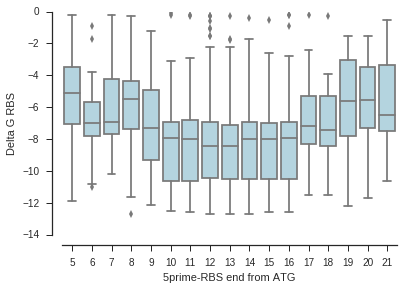

In [16]:
sns.boxplot( data=gg, x='RBS_dist_ATG', y='RBS_dg', color='lightblue', showfliers=True)
sns.set_style('ticks')
sns.despine(offset=10)
plt.xlabel('5prime-RBS end from ATG')
plt.ylabel('Delta G RBS')
plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/deltaG_vs_5primeRBSDistance.pdf',
           bbox_inches='tight')

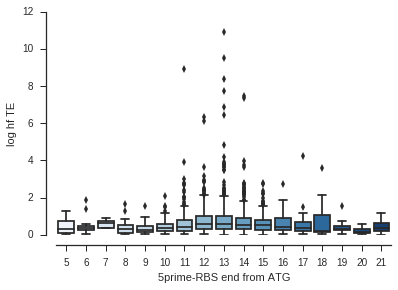

In [927]:
sns.boxplot( data=RBS_df_2, x='RBS_dist_ATG', y='co_te', palette='Blues',showfliers=True)
sns.set_style('ticks')
sns.despine(offset=10)
plt.xlabel('5prime-RBS end from ATG')
plt.ylabel('log hf TE')
#plt.yscale('log')
#plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/deltaG_vs_hf_te.pdf',
#           bbox_inches='tight')

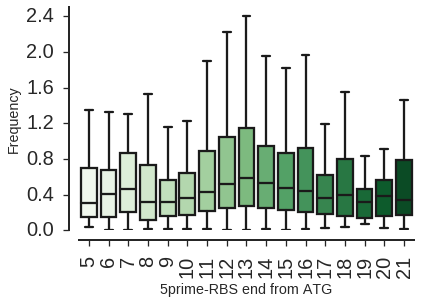

In [69]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,4))
sns.despine(offset=10)
sns.boxplot(data=RBS_df_2, x='RBS_dist_ATG', y='h2c_te',ax=ax, showfliers=False, palette='Greens')
ax.set_yticks([0.0, 0.4, 0.8, 1.2, 1.6, 2.0,2.4])
plt.xlabel('5prime-RBS end from ATG')
plt.ylabel('Frequency')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(90)
    label.set_fontsize(20)
for label in ax.yaxis.get_ticklabels():
    label.set_fontsize(20)
plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/Distribution_of_RBS_distance_from_ATG_nofliers_h2c.pdf',
           bbox_inches='tight')

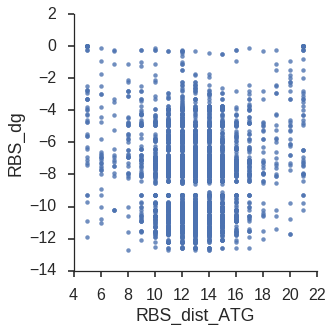

In [18]:
sns.lmplot( data=RBS_df_2, x='RBS_dist_ATG', y='RBS_dg', fit_reg=False)


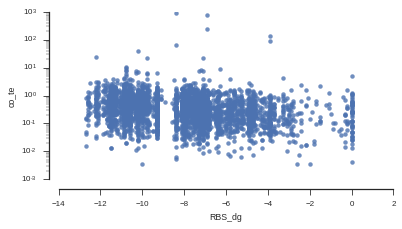

In [40]:
fig, ax=plt.subplots(figsize=(6,3))
sns.regplot(data=RBS_df_2, x='RBS_dg', y='co_te')
sns.set_style('ticks')
sns.despine(offset=10)
sns.set_context('poster')
plt.yscale('log')
plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/co_te_vs_RBS_deltaG.pdf')


In [14]:
RBS_df_2[['co_normalized_RBS','co_te']].dropna().corr(method='spearman')

,co_normalized_RBS,co_te
co_normalized_RBS,1.000000,0.436133
co_te,0.436133,1.000000


In [15]:
subsets=['av_rna_rpkm_co','av_rna_rpkm_hf','av_rna_rpkm_h2c',
        'av_ribo_rpkm_co', 'av_ribo_rpkm_hf', 'av_ribo_rpkm_h2c',
        'co_te', 'hf_te', 'h2c_te']
RBS_df_2=RBS_df_2.replace([np.inf, -np.inf], np.nan).dropna(subset=subsets, how="all")

In [16]:
# first convereted FPKM values to percent 

RBS_df_2['co_percent_rna']=RBS_df_2.av_rna_rpkm_co/RBS_df_2.av_rna_rpkm_co.sum() *100
RBS_df_2['hf_percent_rna']=RBS_df_2.av_rna_rpkm_hf/RBS_df_2.av_rna_rpkm_hf.sum() *100
RBS_df_2['h2c_percent_rna']=RBS_df_2.av_rna_rpkm_h2c/RBS_df_2.av_rna_rpkm_h2c.sum() *100
RBS_df_2['co_percent_ribo']=RBS_df_2.av_ribo_rpkm_co/RBS_df_2.av_ribo_rpkm_co.sum() *100
RBS_df_2['hf_percent_ribo']=RBS_df_2.av_ribo_rpkm_hf/RBS_df_2.av_ribo_rpkm_hf.sum() *100
RBS_df_2['h2c_percent_ribo']=RBS_df_2.av_ribo_rpkm_h2c/RBS_df_2.av_ribo_rpkm_h2c.sum() *100
'''RBS_df_2['co_percent_te']=RBS_df_2.co_te/RBS_df_2.co_te.sum() *100
RBS_df_2['hf_percent_te']=RBS_df_2.hf_te/RBS_df_2.hf_te.sum() *100
RBS_df_2['h2c_percent_te']=RBS_df_2.h2c_te/RBS_df_2.h2c_te.sum() *100'''

"RBS_df_2['co_percent_te']=RBS_df_2.co_te/RBS_df_2.co_te.sum() *100\nRBS_df_2['hf_percent_te']=RBS_df_2.hf_te/RBS_df_2.hf_te.sum() *100\nRBS_df_2['h2c_percent_te']=RBS_df_2.h2c_te/RBS_df_2.h2c_te.sum() *100"

In [17]:
RBS_df_2.h2c_te.sum()

4973.543221043762

In [18]:
co_scatter_df = RBS_df_2[RBS_df_2.co_ave_rbs>0]
hf_scatter_df = RBS_df_2[RBS_df_2.hf_ave_rbs>0]
h2c_scatter_df= RBS_df_2[RBS_df_2.h2c_ave_rbs>0]

In [19]:
co_scatter_df=co_scatter_df.replace([np.inf, -np.inf], np.nan).dropna(subset=["co_normalized_RBS"], how="all")
hf_scatter_df=hf_scatter_df.replace([np.inf, -np.inf], np.nan).dropna(subset=["hf_normalized_RBS"], how="all")
h2c_scatter_df=h2c_scatter_df.replace([np.inf, -np.inf], np.nan).dropna(subset=["h2c_noralized_RBS"], how="all")

In [20]:
co_scatter_df['co_category']=pd.qcut(co_scatter_df.co_normalized_RBS ,q=11, labels=False, )
h2c_scatter_df['h2c_category']=pd.qcut(h2c_scatter_df.h2c_noralized_RBS ,q=11, labels=False )
hf_scatter_df['hf_category']=pd.qcut(hf_scatter_df.hf_normalized_RBS ,q=11, labels=False )

In [21]:
co_scatter_df['dg_co_cat']=pd.qcut(co_scatter_df.RBS_dg.values, q=11, labels=False, precision=5)
h2c_scatter_df['dg_h2c_cat']=pd.qcut(h2c_scatter_df.RBS_dg.values, q=11, labels=False)
hf_scatter_df['dg_hf_cat']=pd.qcut(hf_scatter_df.RBS_dg.values, q=11, labels=False)

In [22]:
co_scatter_df['co_te_cat']=pd.qcut(co_scatter_df.co_te.values, q=11, labels=False)
h2c_scatter_df['h2c_te_cat']=pd.qcut(h2c_scatter_df.h2c_te.values, q=11, labels=False)
hf_scatter_df['hf_te_cat']=pd.qcut(hf_scatter_df.hf_te.values, q=11, labels=False)


In [23]:
xx=pd.qcut(h2c_scatter_df.RBS_dg.values, q=11, labels=False, retbins=True)
xx[1]

array([-12.7, -11.4, -10.8, -10.2,  -9.7,  -8.3,  -7.7,  -7.3,  -6.9,
        -6. ,  -4.8,   0. ])

In [24]:
co_scatter_df.groupby('dg_co_cat')['stop'].count()

dg_co_cat
0     274
1     292
2     354
3     178
4     260
5     277
6     274
7     341
8     190
9     275
10    268
Name: stop, dtype: int64

In [25]:
xx=pd.qcut(hf_scatter_df.hf_te.values, q=11, labels=False, retbins=True)
xx[1]

array([  5.74617268e-03,   1.06346385e-01,   1.67733678e-01,
         2.41099528e-01,   3.26576800e-01,   4.27228377e-01,
         5.41420525e-01,   6.89190992e-01,   8.99559378e-01,
         1.18495481e+00,   1.79862845e+00,   8.70953594e+01])

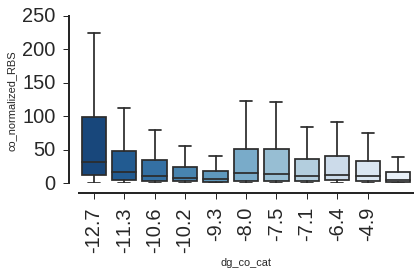

In [26]:
fig, ax = plt.subplots(figsize=(6,3))
sns.set_style('ticks')
sns.despine(offset=10)
sns.boxplot(data=co_scatter_df, x='dg_co_cat', y='co_normalized_RBS', showfliers=False, ax=ax, palette='Blues_r')
plt.xticks(range(0,10), [-12.7, -11.3, -10.6, -10.2,  -9.3,  -8. ,  -7.5,  -7.1,  -6.4,
        -4.9,   0. ])
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(90)
    label.set_fontsize(20)
for label in ax.yaxis.get_ticklabels():
    label.set_fontsize(20)
plt.show()

In [27]:
co_scatter_df.head()

,gene_id,RBS_start,RBS_end,RBS_dg,RBS_seq,product,strand,start,stop,real_st,real_sp,RBS_dist_ATG,id,foldChange_co_hf_ribo,log2FoldChange_co_hf_ribo,padj_co_hf_ribo,foldChange_co_h2c_ribo,log2FoldChange_co_h2c_ribo,padj_co_h2c_ribo,foldChange_hf_h2c_ribo,log2FoldChange_hf_h2c_ribo,padj_hf_h2c_ribo,foldChange_co_hf_rna,log2FoldChange_co_hf_rna,padj_co_hf_rna,foldChange_co_h2c_rna,log2FoldChange_co_h2c_rna,padj_co_h2c_rna,foldChange_hf_h2c_rna,log2FoldChange_hf_h2c_rna,padj_hf_h2c_rna,old_gene_id,av_ribo_rpkm_co,av_ribo_rpkm_hf,av_ribo_rpkm_h2c,av_rna_rpkm_co,av_rna_rpkm_hf,av_rna_rpkm_h2c,co_te,hf_te,h2c_te,co_ave_rbs,hf_ave_rbs,h2c_ave_rbs,co_normalized_RBS,hf_normalized_RBS,h2c_noralized_RBS,co_percent_rna,hf_percent_rna,h2c_percent_rna,co_percent_ribo,hf_percent_ribo,h2c_percent_ribo,co_category,dg_co_cat,co_te_cat
0,CLJU_RS00005,85,94,-9.3,GACTGGAGGA,chromosomal replication initiator protein DnaA,plus,101,1453,101,1453,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CLJU_c00010,30.907470,54.283921,56.255488,302.166750,301.233050,446.001139,0.102286,0.180206,0.126133,5536.0,75494.0,16938.0,18.321010,250.616591,37.977481,0.024229,0.020636,0.034396,0.003193,0.004720,0.005168,6,4,1
1,CLJU_RS00010,1694,1703,-10.9,TAAAGGAGGA,DNA polymerase III subunit beta,plus,1710,2813,1710,2813,12,CLJU_RS00010,0.232834,-2.102623,0.000187,NaN,NaN,NaN,0.176927,-2.498771,0.000046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CLJU_c00020,5.999725,33.563496,5.768107,25.879322,35.111517,31.742726,0.231835,0.955911,0.181714,4360.5,1300.5,742.5,168.493597,37.039129,23.391186,0.002075,0.002405,0.002448,0.000620,0.002919,0.000530,10,1,3
2,CLJU_RS00015,2822,2831,-6.4,AAATTGGAGA,RNA-binding protein,plus,2841,3047,2841,3047,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CLJU_c00030,7.930030,20.794130,18.230279,64.220289,85.874412,64.114905,0.123482,0.242146,0.284338,293.0,329.5,0.0,4.562421,3.836999,0.000000,0.005149,0.005883,0.004945,0.000819,0.001808,0.001675,3,8,1
4,CLJU_RS00025,4221,4230,-8.0,TGAAAGGAGA,hypothetical protein,plus,4236,4499,4236,4499,11,CLJU_RS00025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.395413,-1.260274,3.328286e-07,NaN,NaN,NaN,0.397919,-1.329453,9.167036e-07,CLJU_c00050,12.337119,26.791583,18.526946,132.895890,269.184048,104.904829,0.092833,0.099529,0.176607,1229.0,2669.0,441.0,9.247841,9.915149,4.203810,0.010656,0.018441,0.008090,0.001274,0.002330,0.001702,4,5,1
5,CLJU_RS00030,4500,4509,-10.2,AATAGGAGGA,DNA gyrase subunit B,plus,4517,6430,4517,6430,13,CLJU_RS00030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.102171,-1.071880,1.464587e-06,NaN,NaN,NaN,NaN,NaN,NaN,CLJU_c00060,85.997746,150.986858,86.853551,122.307825,220.417318,111.060718,0.703125,0.685005,0.782037,3248.0,9645.5,1212.0,26.555946,43.760173,10.912949,0.009807,0.015100,0.008565,0.008883,0.013129,0.007979,7,2,8


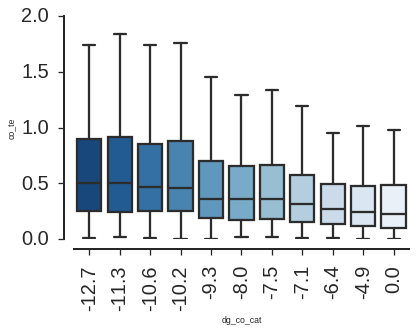

In [50]:
fig, ax = plt.subplots(figsize=(6,4))
sns.set_style('ticks')
sns.set_context('talk')
sns.despine(offset=10)
sns.boxplot(data=co_scatter_df, x='dg_co_cat', y='co_te', showfliers=False, ax=ax, palette='Blues_r')
plt.xticks(range(0,11), [-12.7, -11.3, -10.6, -10.2,  -9.3,  -8. ,  -7.5,  -7.1,  -6.4,
        -4.9,   0. ])
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
#ax.set_yticks([0.0, 1.0, 2.0, 3.0])
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(90)
    label.set_fontsize(20)
for label in ax.yaxis.get_ticklabels():
    label.set_fontsize(20)
plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/co_TE_vs_RBS_deltaG_category_no_liers.pdf', bbox_inches='tight')
plt.show()

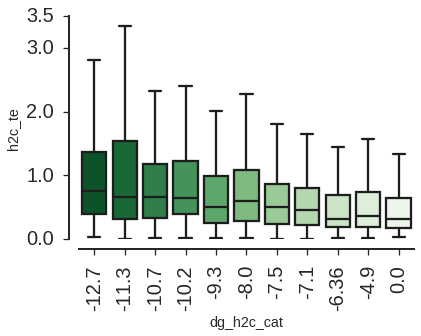

In [51]:
fig, ax = plt.subplots(figsize=(6,4))
sns.set_style('ticks')
sns.despine(offset=10)
sns.boxplot(data=h2c_scatter_df, x='dg_h2c_cat', y='h2c_te', showfliers=False, ax=ax, palette='Greens_r' )
plt.xticks(range(0,11), [-12.7 , -11.3 , -10.7 , -10.2 ,  -9.3 ,  -8.  ,  -7.5 ,  -7.1 ,
        -6.36,  -4.9 ,   0.])
#plt.yscale('log')
'''plt.yticks(range(0,12), [7.4e-03,   1.2e-01,   2.0e-01,
         2.6e-01,   3.5e-01,   4.6e-01,
         5.8e-01,   7.3e-01,   9.3e-01,
         1.3e+00,   1.9e+00,   1.0e+03])'''
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.set_yticks([0.0, 1.0, 2.0 , 3.0, 3.5])
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(90)
    label.set_fontsize(20)
for label in ax.yaxis.get_ticklabels():
    label.set_fontsize(20)
plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/h2c_TE_vs_RBS_deltaG_category_no_liers.pdf', bbox_inches='tight')

plt.show()

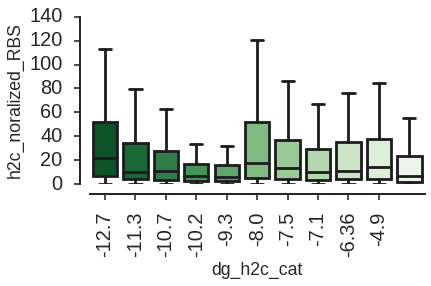

In [22]:
fig, ax = plt.subplots(figsize=(6,3))
sns.set_style('ticks')
sns.despine(offset=10)
sns.boxplot(data=h2c_scatter_df, x='dg_h2c_cat', y='h2c_noralized_RBS', showfliers=False, ax=ax, palette='Greens_r' )
plt.xticks(range(0,10), [-12.7 , -11.3 , -10.7 , -10.2 ,  -9.3 ,  -8.  ,  -7.5 ,  -7.1 ,
        -6.36,  -4.9 ,   0.])
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(90)
    label.set_fontsize(20)
for label in ax.yaxis.get_ticklabels():
    label.set_fontsize(20)
plt.show()

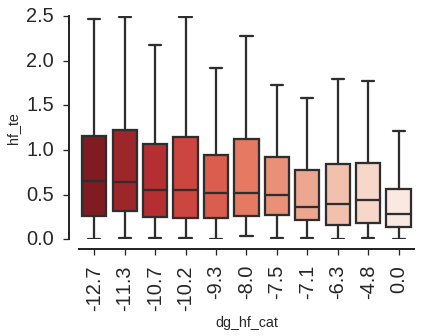

In [52]:
fig, ax = plt.subplots(figsize=(6,4))
sns.set_style('ticks')
sns.despine(offset=10)
sns.boxplot(data=hf_scatter_df, x='dg_hf_cat', y='hf_te', showfliers=False, ax=ax, palette='Reds_r', )
plt.xticks(range(0,11), [-12.7, -11.3, -10.7, -10.2,  -9.3,  -8. ,  -7.5,  -7.1,  -6.3,
        -4.8,   0. ])
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
#plt.yscale('log')
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(90)
    label.set_fontsize(20)
for label in ax.yaxis.get_ticklabels():
    label.set_fontsize(20)
plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/hf_TE_vs_RBS_deltaG_category_noliers.pdf', bbox_inches='tight')

plt.show()

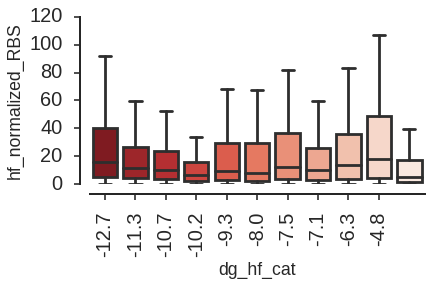

In [24]:
fig, ax = plt.subplots(figsize=(6,3))
sns.set_style('ticks')
sns.despine(offset=10)
sns.boxplot(data=hf_scatter_df, x='dg_hf_cat', y='hf_normalized_RBS', showfliers=False, ax=ax, palette='Reds_r')
plt.xticks(range(0,10), [-12.7, -11.3, -10.7, -10.2,  -9.3,  -8. ,  -7.5,  -7.1,  -6.3,
        -4.8,   0. ])
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(90)
    label.set_fontsize(20)
for label in ax.yaxis.get_ticklabels():
    label.set_fontsize(20)
plt.show()

In [348]:
RBS_df_2.columns.values
ave_te_df=RBS_df_2[['RBS_dg','co_te', 'hf_te','h2c_te']]

In [349]:
ave_te_df.loc[:,'te_av']=ave_te_df[['co_te','hf_te','h2c_te']].mean(axis=1)

In [350]:
ave_te_df.loc[:,'std']=ave_te_df[['co_te','hf_te','h2c_te']].std(axis=1)

In [351]:
ave_te_df=ave_te_df.astype(np.float64)

In [352]:
ave_te_df[(ave_te_df.te_av > ave_te_df['std']) & (ave_te_df.te_av < ave_te_df['std'])]

,RBS_dg,co_te,hf_te,h2c_te,te_av,std


In [353]:
type(ave_te_df.std)

instancemethod

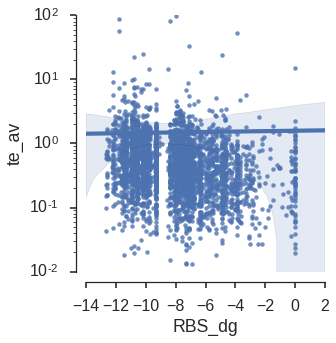

In [354]:
sns.lmplot(data=ave_te_df, x='RBS_dg', y='te_av')
plt.yscale('log')
plt.ylim(0.01,100)
sns.despine(offset=10)

In [391]:
tickarr=np.array(ave_te_df.RBS_dg)

In [392]:
tickarr

array([ -9.3, -10.9,  -6.4, ..., -11.5, -10.2,   0. ])

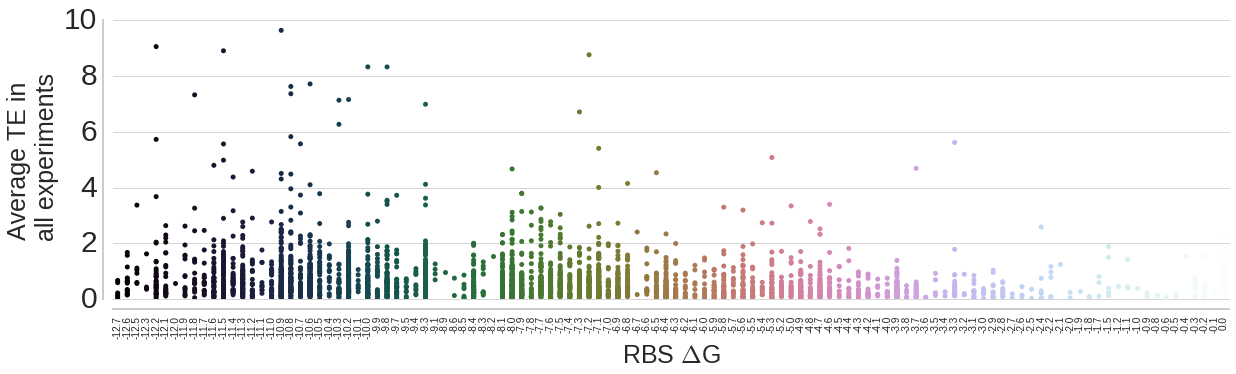

In [402]:
fig, ax = plt.subplots(figsize=(20,5))
sns.set_style('whitegrid')
sns.set_context('paper')
sns.despine(offset=10)
sns.stripplot(data=ave_te_df, x='RBS_dg', y='te_av', ax=ax, palette='cubehelix')
#plt.xticks(range(0,10), [-12.7, -11.3, -10.7, -10.2,  -9.3,  -8. ,  -7.5,  -7.1,  -6.3,
#        -4.8,   0. ])
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.set_ylabel('Average TE in\n all experiments', fontsize=25)
ax.set_xlabel('RBS $\Delta$G', fontsize=25)
#ax.set_yscale('log')
#plt.axhline(y=1, color='pink', linewidth=2, linestyle='dashed')
#plt.axhline(y=1, color='red', linewidth=2, linestyle='dashed', alpha=0.8)

ax.set_ylim(0,10)
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(90)
    label.set_fontsize(10)
for label in ax.yaxis.get_ticklabels():
    label.set_fontsize(30)
plt.show()

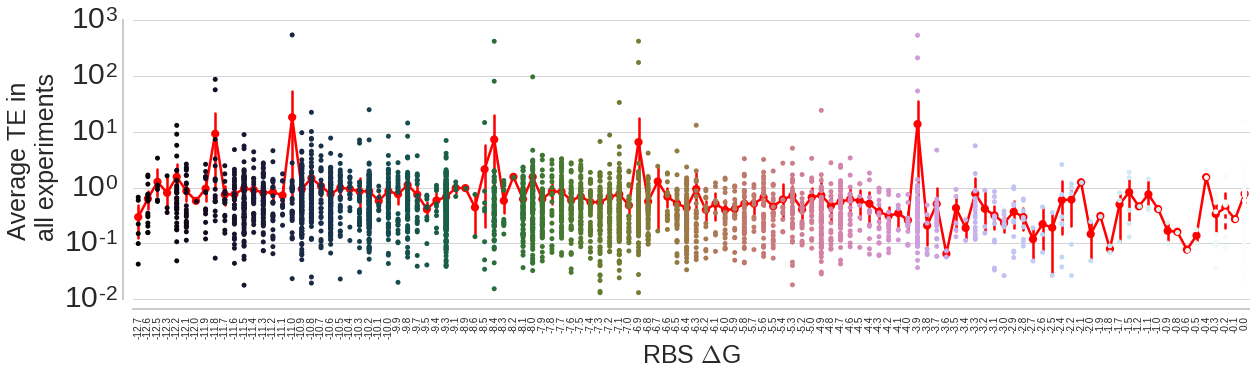

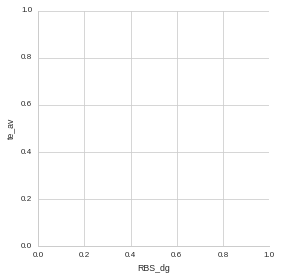

In [445]:
fig, ax = plt.subplots(figsize=(20,5))
sns.set_style('whitegrid')
sns.set_context('paper')
sns.despine(offset=10)
sns.stripplot(data=ave_te_df, x='RBS_dg', y='te_av', ax=ax, palette='cubehelix')

sns.factorplot(data=ave_te_df, x='RBS_dg', y='te_av', ax=ax, err_style="ci_bars", 
               ci=95, color='red', alpha=0.5)

ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.set_ylabel('Average TE in\n all experiments', fontsize=25)
ax.set_xlabel('RBS $\Delta$G', fontsize=25)
ax.set_yscale('log')
#plt.axhline(y=1, color='pink', linewidth=2, linestyle='dashed')
#plt.axhline(y=1, color='red', linewidth=2, linestyle='dashed', alpha=0.8)

for label in ax.xaxis.get_ticklabels():
    label.set_rotation(90)
    label.set_fontsize(10)
for label in ax.yaxis.get_ticklabels():
    label.set_fontsize(30)
plt.show()

## summed mRNA according to -∆G RBS and bar plotting for each experiment
1. convert all FPKM and RPKM values into percent
2. sum mRNAs that are within the same -∆G RBS group for all experiments
3. plot the summed percentages over the -∆G RBS categories

In [308]:
co_scatter_df = co_scatter_df[(co_scatter_df.co_percent_rna>np.percentile(co_scatter_df.co_percent_rna, 0.1))&
                               (co_scatter_df.co_percent_rna<np.percentile(co_scatter_df.co_percent_rna,99))]
hf_scatter_df=hf_scatter_df[(hf_scatter_df.hf_percent_rna>np.percentile(hf_scatter_df.hf_percent_rna,0.1))&
                           (hf_scatter_df.hf_percent_rna<np.percentile(hf_scatter_df.hf_percent_rna,99))]
h2c_scatter_df=h2c_scatter_df[(h2c_scatter_df.h2c_percent_rna>np.percentile(h2c_scatter_df.h2c_percent_rna,0.1))&
                             (h2c_scatter_df.h2c_percent_rna<np.percentile(h2c_scatter_df.h2c_percent_rna,99))]



In [330]:
co_rna_sum=co_scatter_df.groupby(['dg_co_cat'])['co_percent_rna'].sum().to_frame().reset_index()
hf_rna_sum=hf_scatter_df.groupby(['dg_hf_cat'])['hf_percent_rna'].sum().to_frame().reset_index()
h2c_rna_sum=h2c_scatter_df.groupby(['dg_h2c_cat'])['h2c_percent_rna'].sum().to_frame().reset_index()

In [331]:
sum_df = pd.concat([co_rna_sum, hf_rna_sum,h2c_rna_sum], axis=1)

In [332]:
co_ribo_sum=co_scatter_df.groupby(['dg_co_cat'])['co_percent_ribo'].sum().to_frame().reset_index()
hf_ribo_sum=hf_scatter_df.groupby(['dg_hf_cat'])['hf_percent_ribo'].sum().to_frame().reset_index()
h2c_ribo_sum=h2c_scatter_df.groupby(['dg_h2c_cat'])['h2c_percent_ribo'].sum().to_frame().reset_index()

In [333]:
sum_df_ribo = pd.concat([co_ribo_sum, hf_ribo_sum,h2c_ribo_sum], axis=1)

In [334]:
co_te=co_ribo_sum.co_percent_ribo/ co_rna_sum.co_percent_rna
co_te_df=pd.DataFrame(co_te, columns=['co_te'])
hf_te=hf_ribo_sum.hf_percent_ribo/ hf_rna_sum.hf_percent_rna
hf_te_df=pd.DataFrame(hf_te, columns=['hf_te'])
h2c_te=h2c_ribo_sum.h2c_percent_ribo/ h2c_rna_sum.h2c_percent_rna
h2c_te_df=pd.DataFrame(h2c_te, columns=['h2c_te'])
total_te_df = pd.concat([hf_te_df, co_te_df, h2c_te_df], axis=1) 

In [335]:
total_te_df

,hf_te,co_te,h2c_te
0,0.887609,0.970754,1.064273
1,1.523339,1.469885,1.537390
2,1.361930,0.926579,1.053934
3,0.828951,0.808245,0.872909
4,1.058065,1.089950,0.807609
5,1.517191,1.779272,1.255915
6,0.933066,0.885837,0.945343
7,0.617108,0.816769,0.922864
8,0.732317,0.529227,0.728990
9,0.851440,0.492785,0.469585


In [336]:
co_te_sum=co_scatter_df.groupby(['dg_co_cat'])['co_percent_te'].sum().to_frame().reset_index()
hf_te_sum=hf_scatter_df.groupby(['dg_hf_cat'])['hf_percent_te'].sum().to_frame().reset_index()
h2c_te_sum=h2c_scatter_df.groupby(['dg_h2c_cat'])['h2c_percent_te'].sum().to_frame().reset_index()

In [337]:
sum_df_te = pd.concat([co_te_sum, hf_te_sum,h2c_te_sum], axis=1)

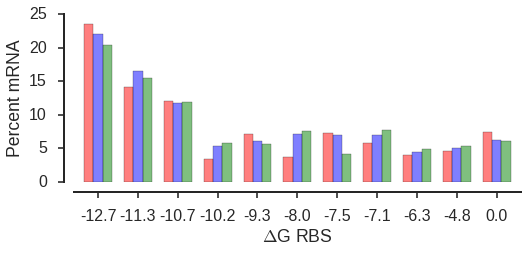

In [344]:
fig,ax=plt.subplots(figsize=[8,3])
my_colors=['red','blue','green']
errors = sum_df[['hf_percent_rna','co_percent_rna','h2c_percent_rna']].std()
sum_df[['hf_percent_rna','co_percent_rna','h2c_percent_rna']].plot(kind='bar',
                                                                  color=my_colors,
                                                                  alpha=0.5, 
                                                                  width=.7, ax=ax,
                                                                  yerr=errors)

plt.xticks(range(0,11), [-12.7, -11.3, -10.7, -10.2,  -9.3,  -8. ,  -7.5,  -7.1,  -6.3,
        -4.8,   0. ])
plt.legend([])
plt.xlabel('$\Delta$G RBS')
plt.ylabel('Percent mRNA')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
sns.set_style('ticks')
sns.despine(offset=10)
plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/RNA-seq_sum_vs_deltaGRBS_allconditions.pdf',
           bbox_inches='tight')
plt.show()

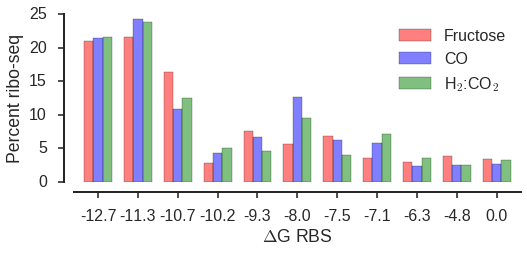

In [343]:
fig,ax=plt.subplots(figsize=[8,3])
my_colors=['red','blue','green']
sum_df_ribo[['hf_percent_ribo','co_percent_ribo','h2c_percent_ribo']].plot(kind='bar',
                                                                  color=my_colors,
                                                                  alpha=0.5, 
                                                                  width=.7, ax=ax,
                                                                  )
plt.xticks(range(0,11), [-12.7, -11.3, -10.7, -10.2,  -9.3,  -8. ,  -7.5,  -7.1,  -6.3,
        -4.8,   0. ])
plt.xlabel('$\Delta$G RBS')
plt.ylabel('Percent ribo-seq')
plt.legend(['Fructose', 'CO', 'H$_2$:CO$_2$'])
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
sns.set_style('ticks')
sns.despine(offset=10)
plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/Ribo-seq_sum_vs_deltaGRBS_allconditions.pdf',
           bbox_inches='tight')
plt.show()

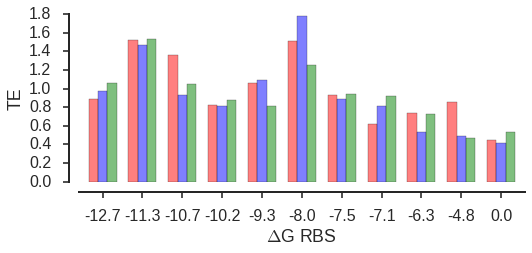

In [345]:
fig,ax=plt.subplots(figsize=[8,3])
my_colors=['red','blue','green']
total_te_df.plot(kind='bar',
                                                                  color=my_colors,
                                                                  alpha=0.5, 
                                                                  width=.7, ax=ax,
                                                                  )
plt.xticks(range(0,11), [-12.7, -11.3, -10.7, -10.2,  -9.3,  -8. ,  -7.5,  -7.1,  -6.3,
        -4.8,   0. ])
plt.xlabel('$\Delta$G RBS')
plt.ylabel('TE')
plt.legend([])
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
sns.set_style('ticks')
sns.despine(offset=10)
plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/TE_vs_deltaGRBS_allconditions.pdf',
           bbox_inches='tight')

plt.show()

In [188]:
sum_df = pd.concat([co_rna_sum, hf_rna_sum,h2c_rna_sum], axis=0)

## Now we want to see which RBS sequence is most abundant in each category. 

In [33]:
seq_sorter=co_scatter_df.groupby(['dg_co_cat','RBS_seq'])['co_te_cat'].count().to_frame()


In [34]:
seq_sorter.reset_index(level=0, inplace=True, col_fill='seq')

In [35]:
#seq_sorter.sort_values(by='RBS_seq',ascending=False, inplace=True)

In [36]:
seq_sorter.index.rename('RBS_seq', 'RBS_sequence')

In [37]:
seq_sorter.reset_index(inplace=True)

In [38]:
seq_sorter.sort_values(by=['dg_co_cat', 'co_te_cat'],ascending=False, inplace=True)

In [39]:
cats=range(0,11)
for i in cats:
    f=open('/home/m/Dropbox/Clostridium_paper/rbs_fasta_for_meme/class{}.fasta'.format(i), 'w')
    for j, x in seq_sorter.iterrows():
        if x['dg_co_cat']==i:
            f.write(">cat{}number{}\n{}\n".format(i,j,x['RBS_seq']))
    f.close()
    
        
        
    

IOError: [Errno 2] No such file or directory: '/home/m/Dropbox/Clostridium_paper/rbs_fasta_for_meme/class0.fasta'

## Trying to model TE based on RBS and mRNA 

In [446]:
RBS_df_2.sort_values(by='av_rna_rpkm_co', inplace=True)

In [447]:
RBS_df_2.columns.values

array([u'gene_id', u'RBS_start', u'RBS_end', u'RBS_dg', u'RBS_seq',
       u'product', u'strand', u'start', u'stop', u'real_st', u'real_sp',
       u'RBS_dist_ATG', u'id', u'foldChange_co_hf_ribo',
       u'log2FoldChange_co_hf_ribo', u'padj_co_hf_ribo',
       u'foldChange_co_h2c_ribo', u'log2FoldChange_co_h2c_ribo',
       u'padj_co_h2c_ribo', u'foldChange_hf_h2c_ribo',
       u'log2FoldChange_hf_h2c_ribo', u'padj_hf_h2c_ribo',
       u'foldChange_co_hf_rna', u'log2FoldChange_co_hf_rna',
       u'padj_co_hf_rna', u'foldChange_co_h2c_rna',
       u'log2FoldChange_co_h2c_rna', u'padj_co_h2c_rna',
       u'foldChange_hf_h2c_rna', u'log2FoldChange_hf_h2c_rna',
       u'padj_hf_h2c_rna', u'old_gene_id', u'av_ribo_rpkm_co',
       u'av_ribo_rpkm_hf', u'av_ribo_rpkm_h2c', u'av_rna_rpkm_co',
       u'av_rna_rpkm_hf', u'av_rna_rpkm_h2c', u'co_te', u'hf_te',
       u'h2c_te', u'co_ave_rbs', u'hf_ave_rbs', u'h2c_ave_rbs',
       u'co_normalized_RBS', u'hf_normalized_RBS', u'h2c_noralized_RBS',


In [448]:
co_df=RBS_df_2[['RBS_dg','co_te', 'av_rna_rpkm_co', 'av_ribo_rpkm_co']]

In [449]:
co_df.sort_values(by='av_rna_rpkm_co', ascending=False, inplace=True)

/home/m/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [450]:
ar=[]
for i, r in co_df.iterrows():
    xx=r['RBS_dg'] * r['av_rna_rpkm_co']
    yy=((co_df.RBS_dg[i:].sum() * co_df.av_rna_rpkm_co[i:].sum())-xx) *(i+1)**2
    ar.append((xx/yy)*1000)

In [451]:
co_df.loc[:,'idx']=ar

(0, 5e-05)

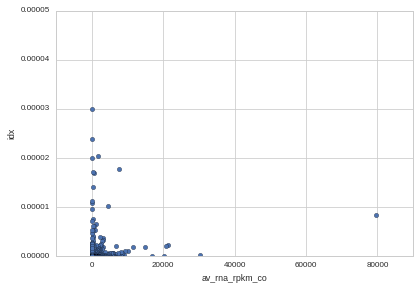

In [452]:
co_df.plot.scatter('av_rna_rpkm_co', 'idx')
plt.ylim(0,0.00005)
#plt.xlim(0,100)

In [453]:
co_df2=co_df[co_df.av_ribo_rpkm_co<np.percentile(co_df.av_ribo_rpkm_co, 50)]

In [454]:
co_df2=co_df2[co_df2.idx>0]

In [455]:
co_df2.loc[:,'idx2']=(1/co_df2.idx)**0.33

In [456]:
co_df2.co_te.corr(co_df2.idx2, method='pearson')

0.49107501961882727

(0, 30)

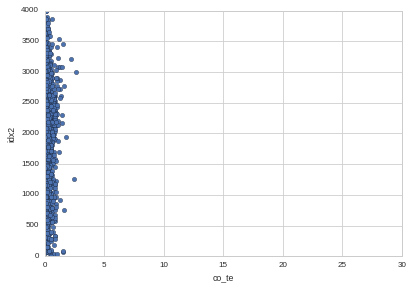

In [457]:
co_df2.plot.scatter('co_te', 'idx2')
plt.ylim(0,4000)
plt.xlim(0,30)

## Analysis of TSS data
1. how 5'UTR length affects TE
2. how 5'UTR secondary structure affets TE (-∆G)
3. We found relationship between RBS and distance of RBS from Start Codon, is there a relation between 5'UTR and RBS? is there evidence that the 5'UTR length is optimized for best TE??

In [718]:
tss = pd.read_csv('/home/m/Dropbox/Clostridium_paper/TSS_analysis/TSS_from_Jinu/tss_categorization_5.csv',
                 sep='\t')
RBS_df_2=pd.read_excel('/home/m/Dropbox/Clostridium_paper/RBS_initation_analysis_20170715.xls')
tss_primary=tss[tss.primary.notnull()]
fivePUTR=pd.merge(tss_primary,RBS_df_2, right_on='gene_id', left_on='primary')
len(fivePUTR)

1194

In [722]:
fivePUTR.columns.values

array(['position', 'primary', 'antisense', 'internal', 'orphan',
       'strand_x', 'intensity', u'gene_id', u'RBS_start', u'RBS_end',
       u'RBS_dg', u'RBS_seq', u'product', u'strand_y', u'start', u'stop',
       u'real_st', u'real_sp', u'RBS_dist_ATG', u'id',
       u'foldChange_co_hf_ribo', u'log2FoldChange_co_hf_ribo',
       u'padj_co_hf_ribo', u'foldChange_co_h2c_ribo',
       u'log2FoldChange_co_h2c_ribo', u'padj_co_h2c_ribo',
       u'foldChange_hf_h2c_ribo', u'log2FoldChange_hf_h2c_ribo',
       u'padj_hf_h2c_ribo', u'foldChange_co_hf_rna',
       u'log2FoldChange_co_hf_rna', u'padj_co_hf_rna',
       u'foldChange_co_h2c_rna', u'log2FoldChange_co_h2c_rna',
       u'padj_co_h2c_rna', u'foldChange_hf_h2c_rna',
       u'log2FoldChange_hf_h2c_rna', u'padj_hf_h2c_rna', u'old_gene_id',
       u'av_ribo_rpkm_co', u'av_ribo_rpkm_hf', u'av_ribo_rpkm_h2c',
       u'av_rna_rpkm_co', u'av_rna_rpkm_hf', u'av_rna_rpkm_h2c', u'co_te',
       u'hf_te', u'h2c_te', u'co_ave_rbs', u'hf_ave_rbs

In [723]:
plus=[]
for i,r in fivePUTR.iterrows():
    if r['strand_x']=='+' and r['strand_y']=='plus':
        plus.append(r['start']-r['position'])
    elif r['strand_x']=='-' and r['strand_y']=='minus':
        plus.append(r['position']-r['stop'])
        

In [724]:
fivePUTR.loc[:,'UTR_length']=plus

In [725]:
fivePUTR.head()

,position,primary,antisense,internal,orphan,strand_x,intensity,gene_id,RBS_start,RBS_end,RBS_dg,RBS_seq,product,strand_y,start,stop,real_st,real_sp,RBS_dist_ATG,id,foldChange_co_hf_ribo,log2FoldChange_co_hf_ribo,padj_co_hf_ribo,foldChange_co_h2c_ribo,log2FoldChange_co_h2c_ribo,padj_co_h2c_ribo,foldChange_hf_h2c_ribo,log2FoldChange_hf_h2c_ribo,padj_hf_h2c_ribo,foldChange_co_hf_rna,log2FoldChange_co_hf_rna,padj_co_hf_rna,foldChange_co_h2c_rna,log2FoldChange_co_h2c_rna,padj_co_h2c_rna,foldChange_hf_h2c_rna,log2FoldChange_hf_h2c_rna,padj_hf_h2c_rna,old_gene_id,av_ribo_rpkm_co,av_ribo_rpkm_hf,av_ribo_rpkm_h2c,av_rna_rpkm_co,av_rna_rpkm_hf,av_rna_rpkm_h2c,co_te,hf_te,h2c_te,co_ave_rbs,hf_ave_rbs,h2c_ave_rbs,co_normalized_RBS,hf_normalized_RBS,h2c_noralized_RBS,UTR_length
0,3105,CLJU_RS00020,NaN,NaN,NaN,+,1,CLJU_RS00020,3100,3109,-3.7,TAAATAGGTG,DNA recombination protein RecF,plus,3117,4217,3117,4217,13,CLJU_RS00020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.456269,-1.132042,9.049980e-06,CLJU_c00040,5.884056,10.831297,5.337636,109.500968,185.040620,82.691535,0.053735,0.058535,0.064549,0.0,0.0,0.0,0.000000,0.000000,0.000000,12
1,15180,CLJU_RS00065,NaN,NaN,NaN,+,4,CLJU_RS00065,15209,15218,-10.0,AGTGGAGGTT,transcriptional regulator,plus,15222,15737,15222,15737,9,CLJU_RS00065,2.589793,1.372837,0.037711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CLJU_c00130,25.069819,12.621185,24.807411,158.674364,116.129753,152.530341,0.157995,0.108682,0.162639,504.5,1152.0,162.0,3.179468,9.919938,1.062084,42
2,20616,CLJU_RS00085,NaN,NaN,NaN,+,3,CLJU_RS00085,20687,20696,-10.5,TTAGGGAGGA,seryl-tRNA synthetase,plus,20707,21987,20707,21987,16,CLJU_RS00085,0.159948,-2.644327,0.006801,NaN,NaN,NaN,0.056398,-4.148213,0.000070,11.740136,-3.553377,0.000582,NaN,NaN,NaN,0.035209,-4.827913,1.765026e-05,CLJU_c00170,101.272309,818.584270,45.162050,90.060027,899.928698,31.079975,1.124498,0.909610,1.453092,1698.0,7364.0,1053.5,18.854092,8.182871,33.896424,91
3,25276,CLJU_RS21180,NaN,NaN,NaN,-,-3,CLJU_RS21180,25269,25278,-7.6,AAGAAGGAGT,phage protein with HTH motif,minus,24696,25259,24696,25259,14,CLJU_RS21180,4.014404,2.005186,0.000246,NaN,NaN,NaN,2.979590,1.575114,0.027014,0.400245,1.321046,0.000060,NaN,NaN,NaN,4.192545,2.067826,9.129010e-08,CLJU_c00220,66.071151,21.324639,62.257673,195.205572,65.697036,269.751472,0.338470,0.324591,0.230796,16710.5,1673.0,11178.0,85.604626,25.465380,41.438143,17
4,31508,CLJU_RS00170,NaN,NaN,NaN,+,5,CLJU_RS00170,31519,31528,-10.2,GTTAGGAGGA,hypothetical protein,plus,31535,31783,31535,31783,12,CLJU_RS00170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.222820,-1.152391,0.000066,NaN,NaN,NaN,NaN,NaN,NaN,CLJU_c00330,54.803626,57.655997,54.956687,49.298075,93.072795,65.357251,1.111679,0.619472,0.840866,4218.0,1078.5,3442.5,85.561150,11.587704,52.672044,27


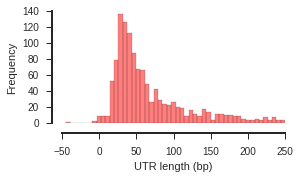

In [726]:
fig, ax =plt.subplots(figsize=(4,2))
fivePUTR.UTR_length.plot(kind='hist', bins=50,alpha=0.5, color='red',)
plt.xlabel('UTR length (bp)')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
sns.set_style('ticks')
sns.despine(offset=10)
plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/UTR_length.pdf',
           bbox_inches='tight')


In [750]:
stats.spearmanr(fivePUTR.h2c_te, fivePUTR.UTR_length)

SpearmanrResult(correlation=0.11175346630612153, pvalue=0.0001089936105615233)

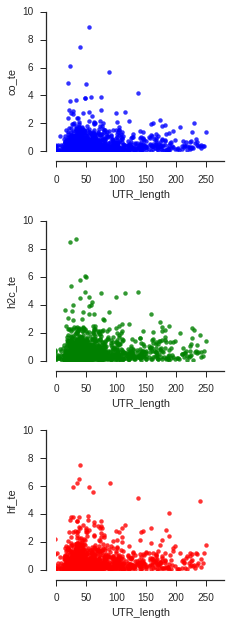

In [742]:
fig, (ax1, ax2, ax3)=plt.subplots(ncols=1, nrows=3,figsize=(3,10))
sns.set_style('ticks')
sns.despine(offset=10)
ax1.set_ylim(0,10)
ax1.set_xlim(0,280)
ax2.set_ylim(0,10)
ax2.set_xlim(0,280)
ax3.set_ylim(0,10)
ax3.set_xlim(0,280)
plt.subplots_adjust(wspace=1, hspace=0.5)
sns.regplot(data=fivePUTR, y='co_te', x='UTR_length',fit_reg=False, color='blue', ax=ax1)
sns.regplot(data=fivePUTR, y='h2c_te', x='UTR_length',fit_reg=False, color='green', ax=ax2)
sns.regplot(data=fivePUTR, y='hf_te', x='UTR_length',fit_reg=False, color='red',ax=ax3)



In [843]:
def percentile_classifier(x): #takes numpy array, or series
    q = pd.qcut(x, q=20, labels=range(1,21))
    return np.array(q)   

In [844]:
#fivePUTR['utr_cat']=pd.qcut(fivePUTR.UTR_length ,q=20, labels=False, )
fivePUTR['utr_cat']=(percentile_classifier(fivePUTR.UTR_length))

AttributeError: 'DataFrame' object has no attribute 'UTR_length'

In [706]:
xx=pd.qcut(fivePUTR.UTR_length, q=10, labels=False, retbins=True)
yy=[]
for i in xx[1]:
    yy.append(str(i).strip())

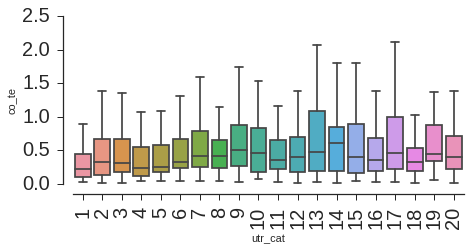

In [737]:
fig, ax=plt.subplots(figsize=(7,3))
sns.set_style('ticks')
sns.despine(offset=10)
ax=sns.boxplot(data=fivePUTR, y='co_te', x='utr_cat',showfliers=False  )
plt.xticks(range(0,20),)
#plt.yscale('log')
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(90)
    label.set_fontsize(20)
for label in ax.yaxis.get_ticklabels():
    label.set_fontsize(20)
plt.show()


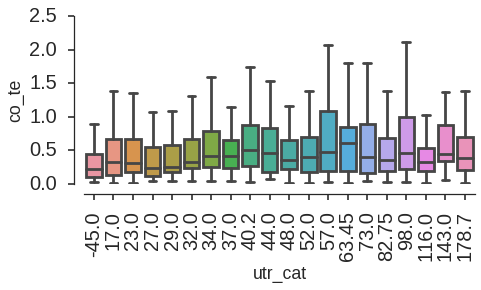

In [623]:
fig, ax=plt.subplots(figsize=(7,3))
sns.set_style('ticks')
sns.despine(offset=10)
ax=sns.boxplot(data=fivePUTR, y='co_te', x='utr_cat',showfliers=False  )
plt.xticks(range(0,20),yy)
#plt.yscale('log')
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(90)
    label.set_fontsize(20)
for label in ax.yaxis.get_ticklabels():
    label.set_fontsize(20)
plt.show()


In [458]:
co_scatter_df['category']=cat_co
hf_scatter_df['category']=cat_hf
h2c_scatter_df['category']=cat_h2c

NameError: name 'cat_co' is not defined

In [ ]:
co_scatter_df.head()

In [ ]:
dg_co=co_scatter_df.groupby('category')['RBS_dg'].sum()/cat_co.value_counts()[0]
dg_co=dg_co[0:len(dg_co)]

dg_h2c=h2c_scatter_df.groupby('category')['RBS_dg'].sum()/cat_h2c.value_counts()[0]
dg_h2c=dg_h2c[0:len(dg_h2c)]

dg_hf=hf_scatter_df.groupby('category')['RBS_dg'].sum()/cat_hf.value_counts()[0]
dg_hf=dg_hf[0:len(dg_hf)]


In [ ]:
fig, ax1 =plt.subplots(figsize=(3,2), sharex=False)

sns.set_style('ticks')
sns.set_context('poster')
sns.despine(offset=10, trim=False,)
ax1.scatter(dg_co, enrichment_co, color='blue', s=40, alpha=0.5 )
ax1.set_ylim(-3,100)
#ax1.set_xlim(-9.2,-7.2)
#ax1.set_yticks([0,20,40,60,80])
#ax1.set_xticks([-7.2, -7.6, -8.0, -8.4, -8.8, -9.2])
ax1.spines['left'].set_linewidth(2)
ax1.spines['bottom'].set_linewidth(2)
for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(90)
    label.set_fontsize(20)
for label in ax1.yaxis.get_ticklabels():
    label.set_fontsize(20)



In [ ]:
sp.stats.spearmanr(dg_co, enrichment_co)

In [ ]:
sp.stats.spearmanr(dg_hf, enrichment_hf)

In [ ]:
fig, ax1 =plt.subplots(figsize=(3,2), sharex=False)

sns.set_style('ticks')
sns.set_context('poster')
sns.despine(offset=10, trim=False,)
ax1.scatter(dg_h2c, enrichment_h2c, color='green', s=40, alpha=0.5 )
ax1.set_ylim(-3,100)
#ax1.set_xlim(-9.2,-7.2)
#ax1.set_yticks([0,20,40,60,80])
#ax1.set_xticks([-7.2, -7.6, -8.0, -8.4, -8.8, -9.2])
ax1.spines['left'].set_linewidth(2)
ax1.spines['bottom'].set_linewidth(2)
for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(90)
    label.set_fontsize(20)
for label in ax1.yaxis.get_ticklabels():
    label.set_fontsize(20)

In [ ]:
sp.stats.spearmanr(dg_h2c, enrichment_h2c)

## 1. Does the A/T regions upstream and downstream affect TE?
## 2. Is there any motif at the coding regions 5 prime end that is enriched in low or high TE genes?

In [60]:
RBS_df_2=pd.read_excel('/home/m/Dropbox/Clostridium_paper/RBS_initation_analysis_20170715.xls')

In [68]:
RBS_df_2=pd.read_excel('/home/m/Dropbox/Clostridium_paper/supplementary_table_20171028.xls')

In [69]:
fasta = np.loadtxt('/home/m/genome_files/NC_014328.fasta', skiprows=1, dtype='str')
fasta = str(fasta)

In [70]:
from Bio.SeqUtils import GC
up_gc=[]
down_gc=[]
upstream=[]
downstream=[]
for i,r in RBS_df_2.iterrows():
    start=r['RBS_start']
    stop = r['RBS_end']
    if r['strand'] == 'plus':
        upstream.append(fasta[start-15:start+2])
        up_gc.append(round(100 - GC(fasta[start-15:start+2])))
        downstream.append(fasta[stop:stop+8])
        down_gc.append(round(100 - GC(fasta[stop:stop+8])))
    elif r['strand']=='minus':
        upstream.append(fasta[stop-2:stop+15])
        up_gc.append(round(100 - GC(fasta[stop-2:stop+15])))
        downstream.append(fasta[start-8:start])
        down_gc.append(round(100 - GC(fasta[start-8:start])))

In [71]:
RBS_df_2.loc[:,'upstream']=upstream
RBS_df_2.loc[:,'downstream']=downstream
RBS_df_2.loc[:,'up_ATpercent']=up_gc
RBS_df_2.loc[:,'down_ATpercent']=down_gc

In [73]:
RBS_df_2.to_excel('/home/m/Dropbox/Clostridium_paper/supplementary_table_with_AU_20171030.xls')

In [67]:
RBS_df_2 = RBS_df_2[(RBS_df_2.av_ribo_rpkm_hf >10) & (RBS_df_2.av_rna_rpkm_hf>10)]
len (RBS_df_2)

2191

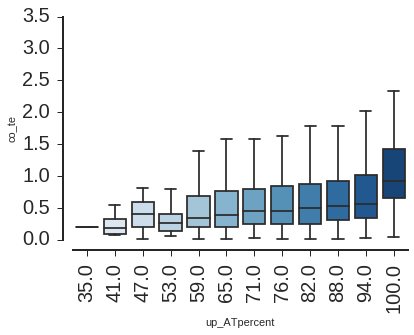

In [916]:
fig, ax = plt.subplots()
sns.set_style('ticks')
sns.despine(offset=10)
sns.boxplot(data=RBS_df_2, x='up_ATpercent', y='co_te', showfliers=False, ax=ax, palette='Blues')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
#ax.set_yscale('log')
ax.set_ylim(0,3.5)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(90)
    label.set_fontsize(20)
for label in ax.yaxis.get_ticklabels():
    label.set_fontsize(20)
plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/correlation_between_AT_upstreamRBS_and_TE_co_regardless_of_TSS.pdf',
           bbox_inches='tight')

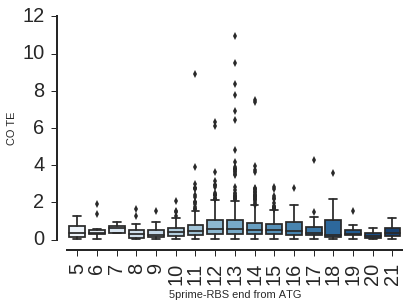

In [943]:
fig, ax = plt.subplots()
sns.boxplot( data=RBS_df_2, x='RBS_dist_ATG', y='co_te', palette='Blues',showfliers=True, ax=ax)
sns.set_style('ticks')
sns.despine(offset=10)
plt.xlabel('5prime-RBS end from ATG')
plt.ylabel('CO TE')
#plt.yscale('log')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(90)
    label.set_fontsize(20)
for label in ax.yaxis.get_ticklabels():
    label.set_fontsize(20)
plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/RBS_distance_vs_co_te.pdf',
           bbox_inches='tight')

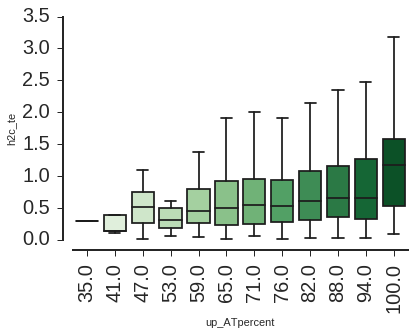

In [904]:
fig, ax = plt.subplots()
sns.set_style('ticks')
sns.despine(offset=10)
sns.boxplot(data=RBS_df_2, x='up_ATpercent', y='h2c_te', showfliers=False, ax=ax, palette='Greens')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
#ax.set_yscale('log')
#ax.set_ylim(-1000,100)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(90)
    label.set_fontsize(20)
for label in ax.yaxis.get_ticklabels():
    label.set_fontsize(20)
plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/correlation_between_AT_upstreamRBS_and_TE_h2c_regardless_of_TSS.pdf',
           bbox_inches='tight')

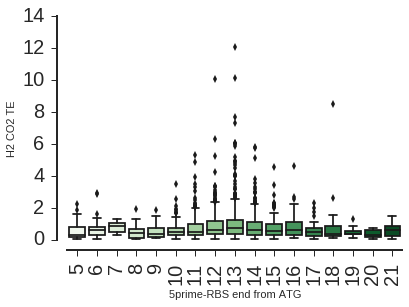

In [937]:
fig, ax = plt.subplots()
sns.boxplot( data=RBS_df_2, x='RBS_dist_ATG', y='h2c_te', palette='Greens',showfliers=True, ax=ax)
sns.set_style('ticks')
sns.despine(offset=10)
plt.xlabel('5prime-RBS end from ATG')
plt.ylabel('H2 CO2 TE')
#plt.yscale('log')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(90)
    label.set_fontsize(20)
for label in ax.yaxis.get_ticklabels():
    label.set_fontsize(20)
plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/RBS_distance_vs_h2c_te.pdf',
           bbox_inches='tight')

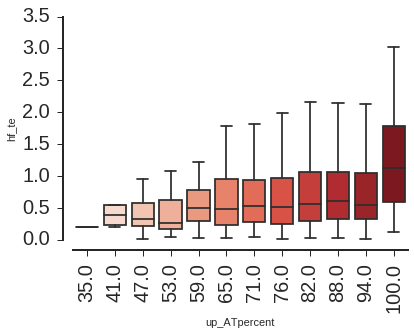

In [910]:
fig, ax = plt.subplots()
sns.set_style('ticks')
sns.despine(offset=10)
sns.boxplot(data=RBS_df_2, x='up_ATpercent', y='hf_te', showfliers=False, ax=ax, palette='Reds')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
#ax.set_yscale('log')
#ax.set_ylim(-1000,100)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(90)
    label.set_fontsize(20)
for label in ax.yaxis.get_ticklabels():
    label.set_fontsize(20)
plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/correlation_between_AT_upstreamRBS_and_TE_hf_regardless_of_TSS.pdf',
           bbox_inches='tight')

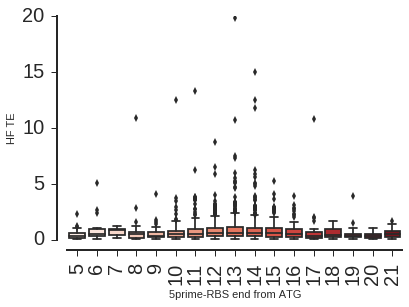

In [958]:
fig, ax = plt.subplots()
sns.boxplot( data=RBS_df_2, x='RBS_dist_ATG', y='hf_te', palette='Reds',showfliers=True, ax=ax)
sns.set_style('ticks')
sns.despine(offset=10)
plt.xlabel('5prime-RBS end from ATG')
plt.ylabel('HF TE')
#plt.yscale('log')
ax.set_ylim(0,20)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(90)
    label.set_fontsize(20)
for label in ax.yaxis.get_ticklabels():
    label.set_fontsize(20)
plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/RBS_distance_vs_hf_te.pdf',
           bbox_inches='tight')

## as Karsten suggested we should only include genes that have TSS at least 15 bp upstream of RBS, since we are estimating the effect of A/T content upstream of RBS on TE

In [140]:
tss = pd.read_csv('/home/m/Dropbox/Clostridium_paper/TSS_analysis/TSS_from_Jinu/tss_categorization_5.csv',
                 sep='\t')
RBS_df_2=pd.read_excel('/home/m/Dropbox/Clostridium_paper/RBS_initation_analysis_20170715.xls')
tss_primary=tss[tss.primary.notnull()]
fivePUTR=pd.merge(tss,RBS_df_2, right_on='gene_id', left_on='primary')
len(fivePUTR)

1194

In [141]:
fivePUTR = fivePUTR[tss.primary.isnull() ==False]
len(fivePUTR)

1018

In [142]:
#conditionals to make sure that TSS is upstream of the AT-rich region which itself is upstream of RBS
fivePUTR=fivePUTR[((fivePUTR.strand_x=='+') & (fivePUTR.RBS_start-15 > fivePUTR.position)) |
          ((fivePUTR.strand_x=='-')& (fivePUTR.RBS_end + 15 < fivePUTR.position))]

In [143]:
from Bio.SeqUtils import GC
up_gc=[]
down_gc=[]
upstream=[]
downstream=[]
for i,r in fivePUTR.iterrows():
    start=r['RBS_start']
    stop = r['RBS_end']
    if r['strand_y'] == 'plus':
        upstream.append(fasta[start-15:start+2])
        up_gc.append(round(100 - GC(fasta[start-15:start+2])))
        downstream.append(fasta[stop:stop+8])
        down_gc.append(round(100 - GC(fasta[stop:stop+8])))
    elif r['strand_y']=='minus':
        upstream.append(fasta[stop-2:stop+15])
        up_gc.append(round(100 - GC(fasta[stop-2:stop+15])))
        downstream.append(fasta[start-8:start])
        down_gc.append(round(100 - GC(fasta[start-8:start])))

In [144]:
len(up_gc)

734

In [145]:
fivePUTR.loc[:,'upstream']=upstream
fivePUTR.loc[:,'downstream']=downstream
fivePUTR.loc[:,'up_ATpercent']=up_gc
fivePUTR.loc[:,'down_ATpercent']=down_gc

In [146]:
fivePUTR=(fivePUTR.replace([np.inf, -np.inf], np.nan))

In [147]:
fivePUTR.dropna(subset=["h2c_te", "co_te", "hf_te", "up_ATpercent"], axis=0, inplace=True)

In [148]:
len(fivePUTR)

731

## calculating statistical significance for AT% effect on TE

In [149]:
from scipy import stats

In [252]:
hi=fivePUTR[(fivePUTR.RBS_dist_ATG == np.percentile(fivePUTR.RBS_dist_ATG, 50)) ].hf_te#|
            #(fivePUTR.RBS_dist_ATG < np.percentile(fivePUTR.RBS_dist_ATG, 50.5))].co_te
lo=fivePUTR[(fivePUTR.RBS_dist_ATG < np.percentile(fivePUTR.RBS_dist_ATG, 15)) |
           (fivePUTR.RBS_dist_ATG > np.percentile(fivePUTR.RBS_dist_ATG, 85))].hf_te

In [253]:
stats.mannwhitneyu(hi, lo)

MannwhitneyuResult(statistic=9607.0, pvalue=0.011457841672782951)

In [245]:
len(lo)

151

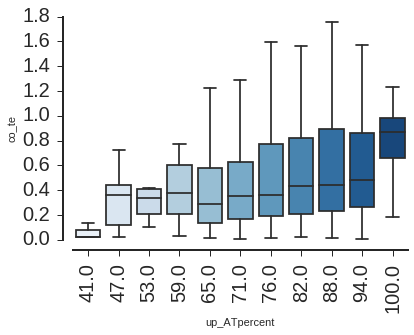

In [237]:
fig, ax = plt.subplots()
sns.set_style('ticks')
sns.despine(offset=10)
sns.boxplot(data=fivePUTR, x='up_ATpercent', y='co_te', showfliers=False, ax=ax, palette='Blues')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
#ax.set_yscale('log')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(90)
    label.set_fontsize(20)
for label in ax.yaxis.get_ticklabels():
    label.set_fontsize(20)
#plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/correlation_between_AT_upstreamRBS_and_TE_co.pdf',
#           bbox_inches='tight')

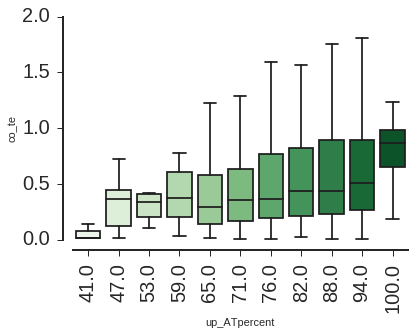

In [869]:
fig, ax = plt.subplots()
sns.set_style('ticks')
sns.despine(offset=10)
sns.boxplot(data=fivePUTR, x='up_ATpercent', y='co_te', showfliers=False, ax=ax, palette='Greens')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
#ax.set_yscale('log')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(90)
    label.set_fontsize(20)
for label in ax.yaxis.get_ticklabels():
    label.set_fontsize(20)
plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/correlation_between_AT_upstreamRBS_and_TE_h2c.pdf',
           bbox_inches='tight')

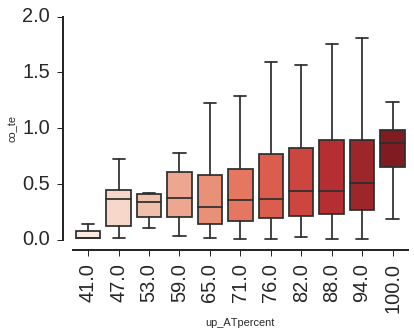

In [870]:
fig, ax = plt.subplots()
sns.set_style('ticks')
sns.despine(offset=10)
sns.boxplot(data=fivePUTR, x='up_ATpercent', y='co_te', showfliers=False, ax=ax, palette='Reds')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
#ax.set_yscale('log')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(90)
    label.set_fontsize(20)
for label in ax.yaxis.get_ticklabels():
    label.set_fontsize(20)
plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/correlation_between_AT_upstreamRBS_and_TE_hf.pdf',
           bbox_inches='tight')

In [644]:
RBS_df_2=(RBS_df_2.replace([np.inf, -np.inf], np.nan).dropna(subset=["RBS_dg", "up_ATpercent", "RBS_dist_ATG", "co_te", "av_rna_rpkm_co"], how="all"))

In [645]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
dg_scalled = scaler.fit_transform(np.array(RBS_df_2.RBS_dg))
AT_scalled = scaler.fit_transform(np.array(RBS_df_2.up_ATpercent))
dist_scalled=scaler.fit_transform(np.array(RBS_df_2.RBS_dist_ATG))
rna_co_scalled=scaler.fit_transform(np.array(RBS_df_2.av_rna_rpkm_co))

/home/m/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/m/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/m/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a s

In [646]:
RBS_df_2.loc[:,'dg_scalled']=dg_scalled
RBS_df_2.loc[:,'AT_scalled']=AT_scalled
RBS_df_2.loc[:,'dist_scalled']=dist_scalled
RBS_df_2.loc[:,'co_rna_scalled']=rna_co_scalled

In [647]:
plot3d = RBS_df_2[['dg_scalled', 'AT_scalled', 'dist_scalled','co_rna_scalled', 'co_te']]

In [654]:
plot3d=(plot3d.replace([np.inf, -np.inf], np.nan).dropna(subset=['dg_scalled', 'AT_scalled', 'dist_scalled','co_rna_scalled', 'co_te'], how="all"))

In [660]:
len(plot3d)

3537

Using matplotlib backend: Qt4Agg


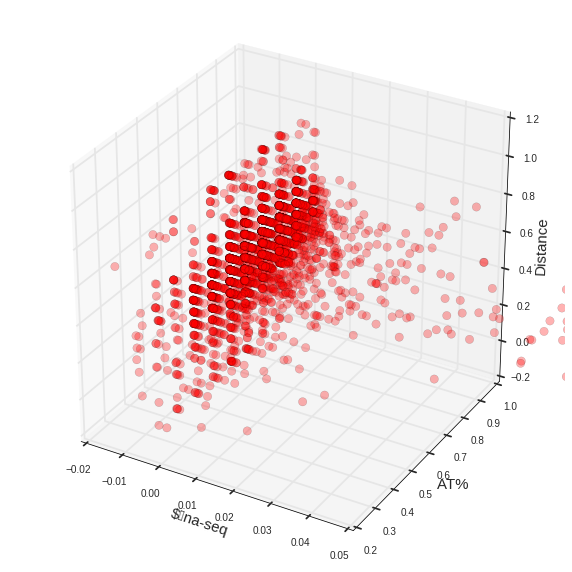

In [889]:
%matplotlib auto
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection='3d')

x =np.array(plot3d.co_rna_scalled)
y =np.array(plot3d.AT_scalled)
z =np.array(plot3d.dist_scalled)



ax.scatter(x, y, z, c='r', marker='o', s=70 ,alpha=0.3)

ax.set_xlabel('$\rna-seq', fontsize=15)
ax.set_xlim(-0.02,0.05)
ax.set_ylabel('AT%', fontsize=15)
ax.set_ylim(0.2,1)
ax.set_zlabel('Distance', fontsize=15)


(nan, 1.0)


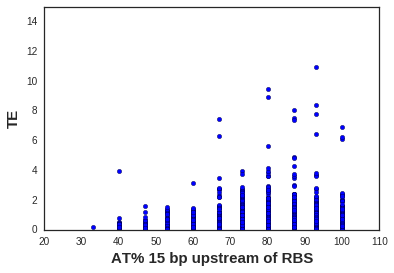

In [143]:
df= RBS_df_2[['up_ATpercent','RBS_dg','co_te']]
from scipy import stats
r2 = stats.pearsonr(RBS_df_2.up_ATpercent, RBS_df_2.co_te)
print r2
plt.scatter(data=df, x='up_ATpercent', y='co_te')
plt.ylim(0,15)
plt.xlabel('AT% 15 bp upstream of RBS', fontsize=15, fontweight='bold')
plt.ylabel('TE', fontsize=15, fontweight='bold')

In [163]:
RBS_df_2.plot(kind='kde', 'co_te')

SyntaxError: non-keyword arg after keyword arg (<ipython-input-163-4348652a4d96>, line 1)

In [131]:
## base results on df that only has rpkm 10 and above for Ribo-seq and 100 for RNA-seq
df2 = RBS_df_2[(RBS_df_2.av_ribo_rpkm_co>10) & (RBS_df_2.av_rna_rpkm_co>100)]
len(df2), len(RBS_df_2)

(1227, 3537)

In [169]:
df=df.replace(['inf', '-inf'], 'NaN', inplace=True)

/home/m/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [171]:
df

In [170]:
df[df.co_te.isnull() == False].plot(kind='kde')

AttributeError: 'NoneType' object has no attribute 'co_te'

In [175]:
highte = df2[df2.co_te >np.percentile(df2.co_te, 75)]
lowte = df2[df2.co_te< np.percentile(df2.co_te, 25)]

In [176]:
len(highte), len(lowte)

(307, 307)

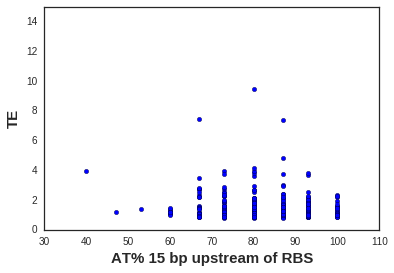

In [179]:
df= RBS_df_2[['up_ATpercent','RBS_dg','co_te']]
plt.scatter(data=highte, x='up_ATpercent', y='co_te')
plt.ylim(0,15)
plt.xlabel('AT% 15 bp upstream of RBS', fontsize=15, fontweight='bold')
plt.ylabel('TE', fontsize=15, fontweight='bold')

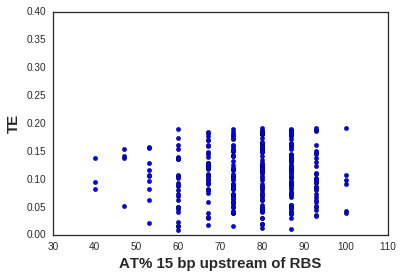

In [180]:
df= RBS_df_2[['up_ATpercent','RBS_dg','co_te']]
plt.scatter(data=lowte, x='up_ATpercent', y='co_te')
plt.ylim(0,0.4)
plt.xlabel('AT% 15 bp upstream of RBS', fontsize=15, fontweight='bold')
plt.ylabel('TE', fontsize=15, fontweight='bold')